### Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline


#### Step 2: Examine your data 

In [3]:
airport_cancellations_df = pd.read_csv("./assets/airport_cancellations.csv")
airport_cancellations_df = airport_cancellations_df.dropna() 
airport_cancellations_df[:3]

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0


In [4]:
airport_operations_df = pd.read_csv("./assets/airport_operations.csv")
airport_operations_df = airport_operations_df.dropna() 
airport_operations_df[:3]

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82


In [5]:
airports_df = pd.read_csv("./assets/airports.csv")
airports_df = airports_df.dropna() 
airports_df[:3]

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes


### Intro: Write a problem statement / aim for this project

We want to understand the behavior of flight cancellations
Answer: How are we going to do this?

### Part 1: Create a SQLite database 

#### 1. Let's create a database where we can house our airport data

In [6]:
import pandas as pd
from pandas.io import sql

import sqlite3
sqlite_db = 'airportreport.sqlite'
conn = sqlite3.connect(sqlite_db)

Load our csv files into tables

In [7]:
# Import data, encode UTF-8 during import to eliminate special character errors

pd.read_csv('./assets/airport_cancellations.csv',encoding='utf-8').to_sql('cancellations',con=conn,if_exists='replace',index=False)
pd.read_csv('./assets/airport_operations.csv',encoding='utf-8').to_sql('operations',con=conn,if_exists='replace',index=False)
pd.read_csv('./assets/airports.csv',encoding='utf-8').to_sql('airports',con=conn,if_exists='replace',index=False)

Join airport_cancellations.csv and airports.csv into one table (try to do it with both pandas and SQLite)

In [8]:
#airport_df = pd.read_csv('airports.csv')

In [9]:
# LocID in airports.csv 
# is the same as Airport in airport_cancellations.csv
# so these are what you would join on ...


#joined_df = pd.merge(airport_cancellations_df,airport_df,
#                     left_on = 'Airport', right_on = 'LocID')


In [10]:
#joined_df[:3]

Query the database for our intial data

In [11]:
# query while renaming columns.

cur = conn.cursor()
cur.execute("""SELECT * FROM (SELECT * FROM cancellations JOIN airports on (airports.LocID = cancellations.Airport) JOIN operations on (operations.airport = cancellations.Airport))
""")
ap = cur.fetchall()

airmetrics_columns = ['airport','year','d_cancel','a_cancel','d_diversion','a_diversion',
                     'key','locid','ap_name','alias','facility_type','faa_region',
                     'county','city','state','ap_type','lat','long','bda','airport_1',
                     'year_1','dep_for_mc','arr_for_mc','p_gd_ontime','p_ad_ontime','p_ga_ontime',
                     'avg_gd_delay','avg_taxi_out_time','avg_taxi_out_delay','avg_ad_delay','avg_airbourne_delay',
                     'avg_taxi_in_delay','avg_block_delay','avg_ga_delay']

airmetrics_raw = pd.DataFrame(ap, columns=airmetrics_columns)

In [12]:
# Raw dataframe created from sql pull.

airmetrics_raw

,airport,year,d_cancel,a_cancel,d_diversion,a_diversion,key,locid,ap_name,alias,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48
5,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.8147,0.8224,9.24,9.88,1.89,10.45,1.74,0.92,1.98,9.27
6,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7907,0.8047,10.25,9.95,2.05,11.58,1.66,0.95,1.90,10.23
7,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7758,0.8022,10.81,10.50,2.51,12.57,1.58,0.84,1.87,10.63
8,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7940,0.8177,10.55,10.27,2.32,12.11,1.41,0.98,1.80,9.73
9,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7402,0.7554,12.56,10.77,2.64,14.28,1.60,0.92,2.35,12.76


In [481]:
#inspect dataframe.

airmetrics_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8789 entries, 0 to 8788
Data columns (total 34 columns):
airport                8789 non-null object
year                   8789 non-null float64
d_cancel               8789 non-null float64
a_cancel               8789 non-null float64
d_diversion            8789 non-null float64
a_diversion            8789 non-null float64
key                    8789 non-null float64
locid                  8789 non-null object
ap_name                8789 non-null object
alias                  8789 non-null object
facility_type          8789 non-null object
faa_region             8789 non-null object
county                 8789 non-null object
city                   8789 non-null object
state                  8789 non-null object
ap_type                8789 non-null object
lat                    8789 non-null float64
long                   8789 non-null float64
bda                    8789 non-null object
airport_1              8789 non-null object
year_

#### 1.2 What are the risks and assumptions of our data? 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [13]:
#ap.head()
#ap.describe()

airmetrics_raw.describe()

,year,d_cancel,a_cancel,d_diversion,a_diversion,key,lat,long,year_1,dep_for_mc,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
count,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,...,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000
mean,2008.986233,1299.328706,1341.021277,174.227216,170.384117,1714.484355,36.448807,-94.899998,2009.030038,113462.406531,...,0.726757,0.766806,12.898230,13.873027,3.680732,15.712726,2.876105,1.413830,3.290090,13.436961
std,3.156287,1839.807086,1979.344326,172.550372,228.966130,1004.487202,6.682976,20.633247,3.154389,98013.586104,...,0.075708,0.050351,3.020389,3.804768,2.338027,4.348108,1.168646,0.854782,0.987058,3.244237
min,2004.000000,0.000000,0.000000,0.000000,0.000000,246.000000,18.439295,-157.922429,2004.000000,360.000000,...,0.380800,0.513600,5.350000,7.040000,0.100000,6.290000,0.950000,0.000000,1.230000,6.330000
25%,2006.000000,349.000000,314.000000,62.000000,41.000000,770.000000,32.896828,-111.977773,2006.000000,41845.000000,...,0.691800,0.742200,10.840000,11.470000,2.300000,12.890000,2.040000,0.840000,2.620000,11.270000
50%,2009.000000,670.000000,653.000000,111.000000,85.000000,1531.000000,37.618972,-87.897068,2009.000000,79489.000000,...,0.740200,0.770500,12.540000,12.940000,3.050000,15.100000,2.620000,1.140000,3.130000,12.970000
75%,2012.000000,1484.000000,1549.000000,238.000000,190.000000,2502.000000,40.795250,-80.152741,2012.000000,166479.000000,...,0.773500,0.797600,14.620000,15.750000,4.230000,17.560000,3.560000,1.780000,3.800000,14.940000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,3575.000000,61.174083,-66.002004,2014.000000,491826.000000,...,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000


In [14]:
airmetrics_raw.columns

Index([u'airport', u'year', u'd_cancel', u'a_cancel', u'd_diversion',
       u'a_diversion', u'key', u'locid', u'ap_name', u'alias',
       u'facility_type', u'faa_region', u'county', u'city', u'state',
       u'ap_type', u'lat', u'long', u'bda', u'airport_1', u'year_1',
       u'dep_for_mc', u'arr_for_mc', u'p_gd_ontime', u'p_ad_ontime',
       u'p_ga_ontime', u'avg_gd_delay', u'avg_taxi_out_time',
       u'avg_taxi_out_delay', u'avg_ad_delay', u'avg_airbourne_delay',
       u'avg_taxi_in_delay', u'avg_block_delay', u'avg_ga_delay'],
      dtype='object')

In [15]:
airport_operations_df.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [374]:
# try shrinking dataframe into average departure and arrival delays for visual overview

airport_operations_df[['airport','year','average_gate_departure_delay','average gate arrival delay']].head(15)

,airport,year,average_gate_departure_delay,average gate arrival delay
0,ABQ,2004,10.38,10.87
1,ABQ,2005,9.60,10.24
2,ABQ,2006,10.84,11.82
3,ABQ,2007,11.29,12.71
4,ABQ,2008,10.79,11.48
5,ABQ,2009,9.24,9.27
6,ABQ,2010,10.25,10.23
7,ABQ,2011,10.81,10.63
8,ABQ,2012,10.55,9.73
9,ABQ,2013,12.56,12.76


In [521]:
# Graphing version 1. Individual graphs over year of departure delays

for airport in np.unique(airport_operations_df['airport']):
    delay_df = pd.DataFrame(airport_operations_df[airport_operations_df['airport']==airport]
                            [['year','average_gate_departure_delay','average gate arrival delay']])
#    This was not used as it gives us a WTF Visualization. 
#    plt.rcParams["figure.figsize"] = [5.0,5.0]

    # plotting command to spit out separate departure graphs for each airport

#     plt.figure()
#     plt.plot(delay_df.year,delay_df.average_gate_departure_delay)
#     plt.xlabel('Year')
#     plt.ylabel('Avg Departure Delay')
#     plt.title('Yearly Avg Departure Delay - %s'%airport)
#     plt.plot()

In [522]:
# Graphing version 1. Individual graphs over year of arrival delays

for airport in np.unique(airport_operations_df['airport']):
    delay_df = pd.DataFrame(airport_operations_df[airport_operations_df['airport']==airport]
                            [['year','average_gate_departure_delay','average gate arrival delay']])
#    This was not used as it gives us a WTF Visualization. 
#    plt.rcParams["figure.figsize"] = [5.0,5.0]

#     plt.figure()
#     plt.plot(delay_df.year,delay_df['average gate arrival delay'])
#     plt.xlabel('Year')
#     plt.ylabel('Avg Arrival Delay')
#     plt.title('Yearly Avg Arrival Delay - %s'%airport)
#     plt.plot

In [491]:
# Graphing version 2, zoomed out overview side by side of all airports.

grid_delay_df = airport_operations_df[['airport','year','average_gate_departure_delay','average gate arrival delay']].groupby('airport')

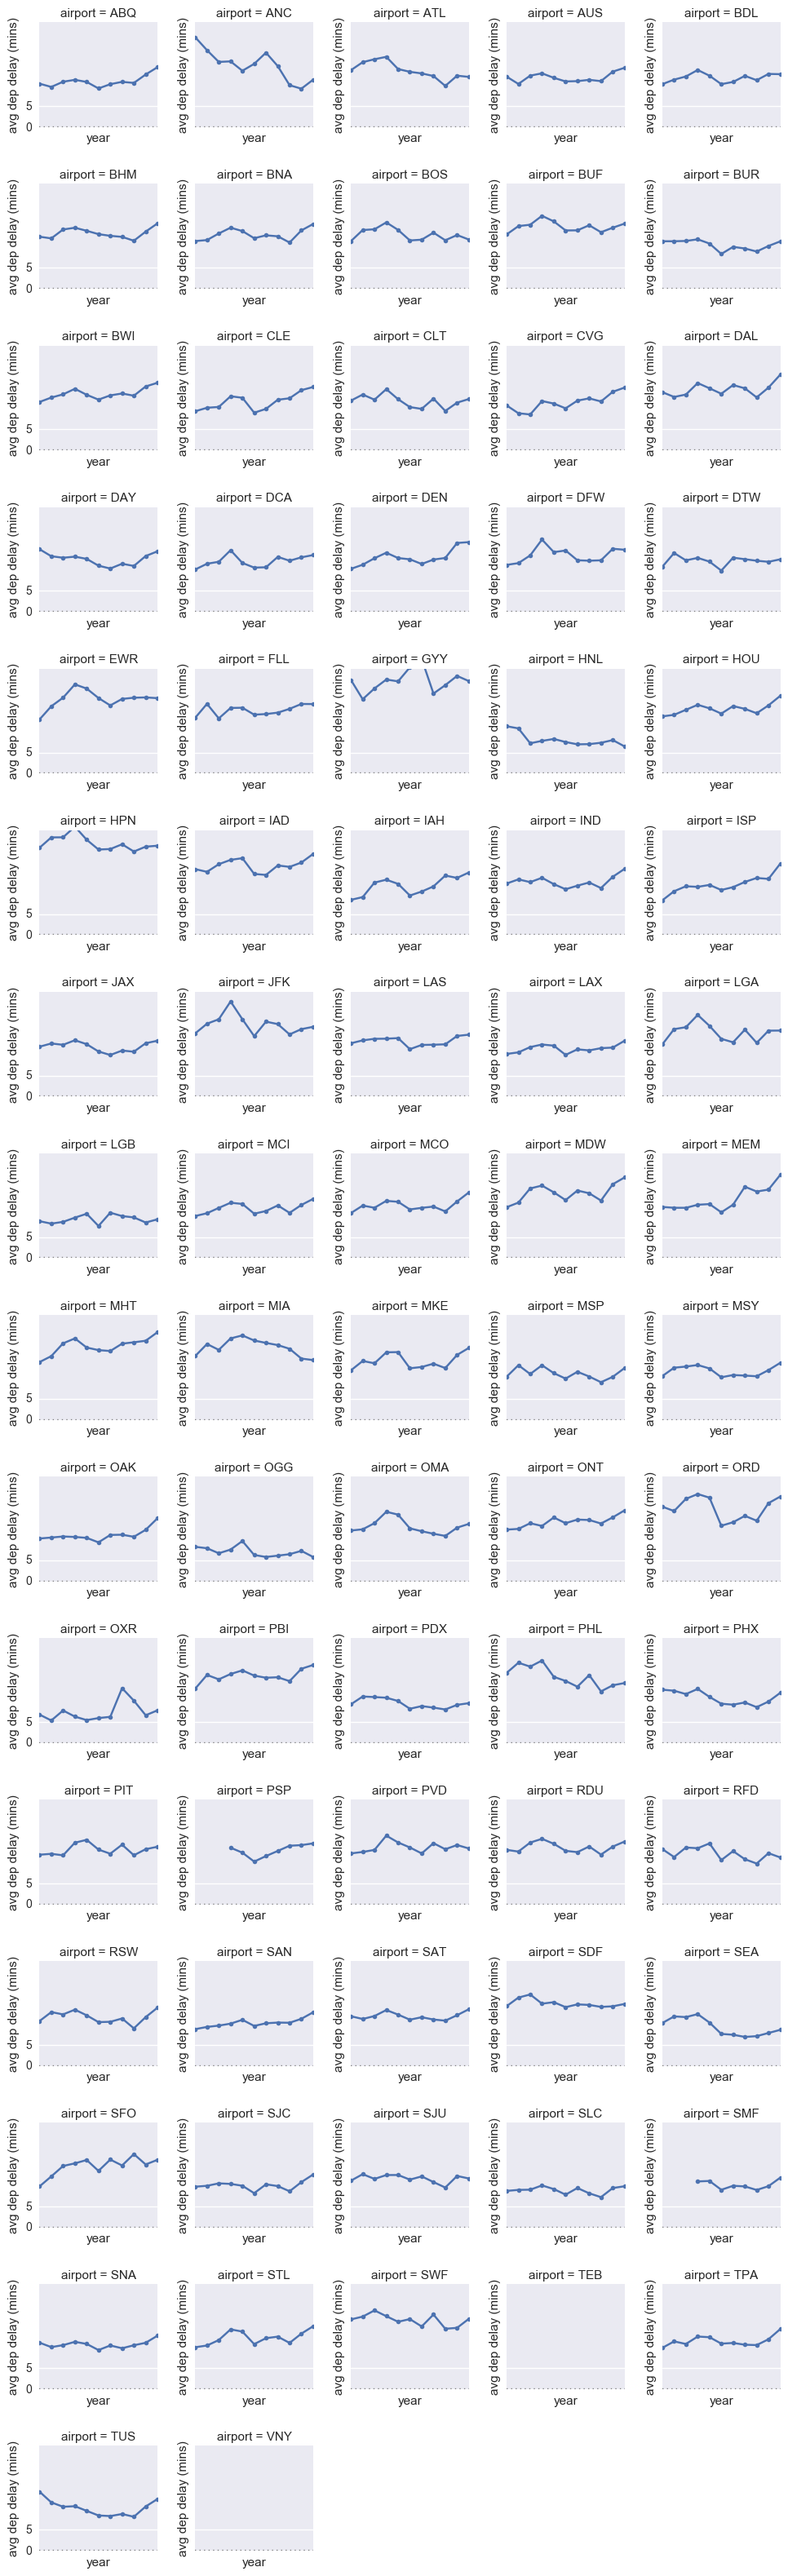

In [511]:
# Initialize a grid of plots with an Axes for each walk
airgrid = sns.FacetGrid(airport_operations_df[['airport','year','average_gate_departure_delay']], col="airport", col_wrap=5, size=2)

# Draw a horizontal line to show the starting point
airgrid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
airgrid.map(plt.plot, "year", "average_gate_departure_delay", marker="o", ms=4)

airgrid.set(ylabel="avg dep delay (mins)",xlabel="year")

# Adjust the tick positions and labels
airgrid.set(xticks=np.arange(5), yticks=[0, 5],xlim=(2004, 2014), ylim=(0, 25))

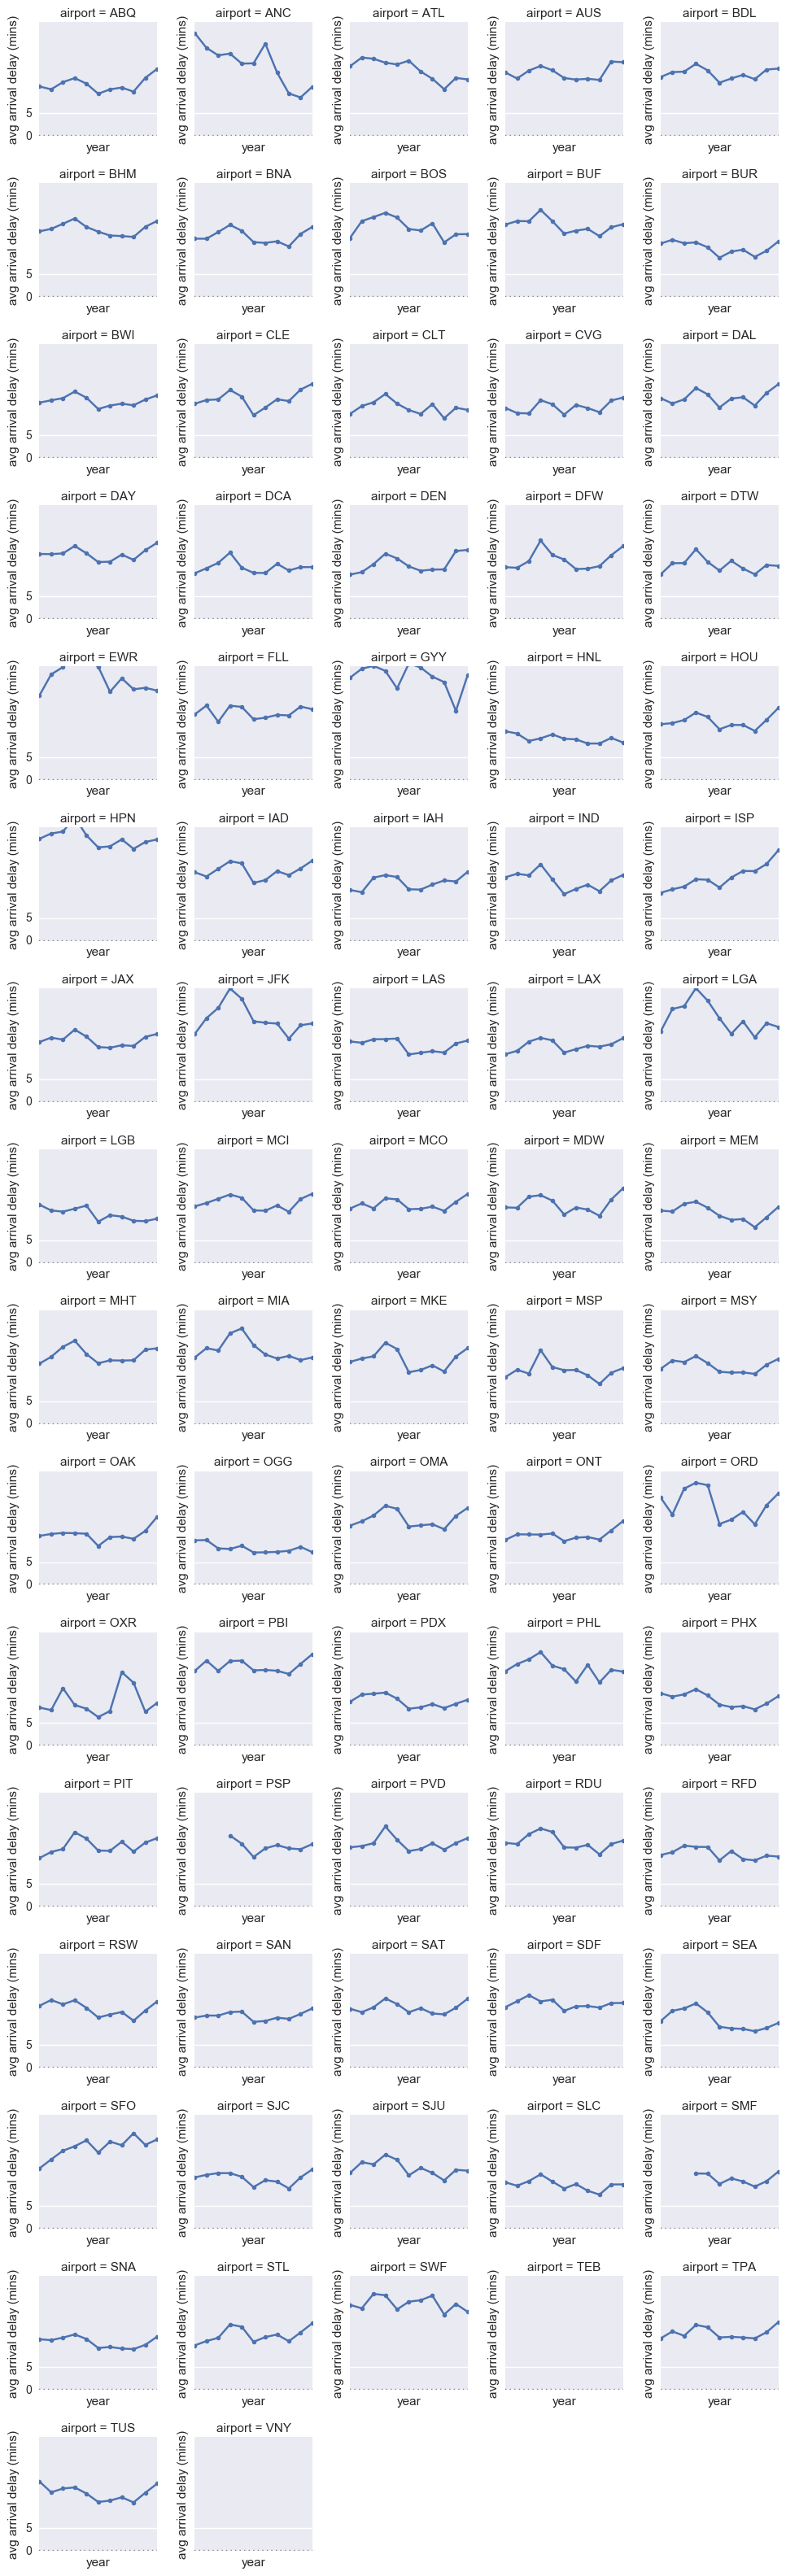

In [510]:
# Initialize a grid of plots with an Axes for each walk
airgrid = sns.FacetGrid(airport_operations_df[['airport','year','average gate arrival delay']], col="airport", col_wrap=5, size=2)

# Draw a horizontal line to show the starting point
airgrid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
airgrid.map(plt.plot, "year", "average gate arrival delay", marker="o", ms=4)

airgrid.set(ylabel="avg arrival delay (mins)",xlabel="year")

# Adjust the tick positions and labels
airgrid.set(xticks=np.arange(5), yticks=[0, 5],xlim=(2004, 2014), ylim=(0, 25))

# Adjust the arrangement of the plots
#airgrid.fig.tight_layout(w_pad=3)

In [19]:
# These graphs show we might want to take a look at features for airports with 
# drastic increases between 2012-2014. 

# The below was tried before hearing about the suggestion to cluster between good and bad airports.
# the work below attempted to find a way to be able to manually identify and separate good and 
# bad airports by the rate of the delays over the 2012-2014 period. This work was ultimately NOT
# used for the analysis.

In [20]:
airport_operations_df.head(2)

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


In [21]:
delay_frame = pd.DataFrame(airport_operations_df[airport_operations_df['year'] >= 2012][['airport','year','average_gate_departure_delay','average gate arrival delay']])

In [22]:
delay_frame.head()

,airport,year,average_gate_departure_delay,average gate arrival delay
8,ABQ,2012,10.55,9.73
9,ABQ,2013,12.56,12.76
10,ABQ,2014,14.30,14.72
19,ANC,2012,10.01,9.33
20,ANC,2013,9.18,8.46


In [23]:
dep_delay_diff = []
for airport in np.unique(airport_operations_df['airport']):
    delay_2014 = delay_frame[delay_frame['airport']==airport][delay_frame['year']==2014]['average_gate_departure_delay'].values
    delay_2012 = delay_frame[delay_frame['airport']==airport][delay_frame['year']==2012]['average_gate_departure_delay'].values
    dep_delay_diff.append([airport,(delay_2014-delay_2012)[0]])
    
dep_delay_diff_df = pd.DataFrame(dep_delay_diff,columns=['airport','dep_delay_diff'])

In [24]:
dep_delay_diff_df.head()

,airport,dep_delay_diff
0,ABQ,3.75
1,ANC,1.32
2,ATL,2.15
3,AUS,3.18
4,BDL,1.44


In [25]:
dep_delay_diff_df.sort_values('dep_delay_diff',ascending=False).head()

,airport,dep_delay_diff
49,ORD,5.76
38,MDW,5.51
14,DAL,5.42
60,RSW,4.92
42,MKE,4.81


In [26]:
# Get metrics for departures.

dep_delay_diff_df.sort_values('dep_delay_diff',ascending=False).describe()

,dep_delay_diff
count,77.000000
mean,2.388701
std,1.748965
min,-2.690000
25%,1.380000
50%,2.600000
75%,3.490000
max,5.760000


In [27]:
# spliy by top/bottom quartile of airports

dep_delay_diff_df[dep_delay_diff_df['dep_delay_diff']>=3.49]['airport'].values

array(['ABQ', 'BHM', 'BNA', 'DAL', 'DAY', 'DEN', 'HOU', 'IND', 'MCO',
       'MDW', 'MEM', 'MKE', 'OAK', 'ORD', 'PBI', 'RSW', 'SJC', 'STL',
       'TPA', 'TUS'], dtype=object)

In [28]:
dep_bad_airports = dep_delay_diff_df.sort_values('dep_delay_diff',ascending=False)[dep_delay_diff_df['dep_delay_diff']>=3.49]['airport'].values
dep_good_airports = dep_delay_diff_df.sort_values('dep_delay_diff',ascending=False)[dep_delay_diff_df['dep_delay_diff']<=1.38]['airport'].values

In [29]:
dep_bad_airports

array(['ORD', 'MDW', 'DAL', 'RSW', 'MKE', 'IND', 'MCO', 'BNA', 'OAK',
       'TUS', 'HOU', 'BHM', 'SJC', 'STL', 'MEM', 'PBI', 'TPA', 'DEN',
       'ABQ', 'DAY'], dtype=object)

In [30]:
dep_good_airports

array(['HPN', 'DCA', 'ANC', 'FLL', 'TEB', 'GYY', 'IAH', 'SDF', 'PSP',
       'VNY', 'DTW', 'PVD', 'BOS', 'EWR', 'LGB', 'OGG', 'HNL', 'SFO',
       'OXR', 'MIA'], dtype=object)

In [31]:
bad_gd_df = airmetrics_raw[airmetrics_raw['airport'].isin(dep_bad_airports)]
good_gd_df = airmetrics_raw[airmetrics_raw['airport'].isin(dep_good_airports)]

In [32]:
arr_delay_diff = []
for airport in np.unique(airport_operations_df['airport']):
    arr_delay_2014 = delay_frame[delay_frame['airport']==airport][delay_frame['year']==2014]['average gate arrival delay'].values
    arr_delay_2012 = delay_frame[delay_frame['airport']==airport][delay_frame['year']==2012]['average gate arrival delay'].values
    arr_delay_diff.append([airport,(arr_delay_2014-arr_delay_2012)[0]])
    
arr_delay_diff_df = pd.DataFrame(arr_delay_diff,columns=['airport','arr_delay_diff'])

In [33]:
arr_delay_diff_df.describe()

,arr_delay_diff
count,77.000000
mean,2.696623
std,1.769513
min,-4.440000
25%,1.830000
50%,2.720000
75%,3.960000
max,6.780000


In [34]:
arr_bad_airports = arr_delay_diff_df.sort_values('arr_delay_diff',ascending=False)[arr_delay_diff_df['arr_delay_diff']>=3.96]['airport'].values
arr_good_airports = arr_delay_diff_df.sort_values('arr_delay_diff',ascending=False)[arr_delay_diff_df['arr_delay_diff']<=1.83]['airport'].values

In [35]:
bad_ga_df = airmetrics_raw[airmetrics_raw['airport'].isin(arr_bad_airports)]
good_ga_df = airmetrics_raw[airmetrics_raw['airport'].isin(arr_good_airports)]

In [36]:
bad_ga_df.head()

,airport,year,d_cancel,a_cancel,d_diversion,a_diversion,key,locid,ap_name,alias,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [37]:
bad_gd_df.groupby('year').mean()

,d_cancel,a_cancel,d_diversion,a_diversion,key,lat,long,year_1,dep_for_mc,arr_for_mc,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
year,,,,,,,,,,,,,,,,,,,,,
2004.0,1331.40,1349.50,133.10,118.30,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2005.0,1104.35,1126.45,146.55,112.35,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2006.0,1414.55,1449.40,162.65,164.50,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2007.0,1756.20,1804.00,173.45,160.25,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2008.0,1626.15,1669.35,186.95,190.40,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2009.0,918.75,961.15,166.50,149.20,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2010.0,1112.85,1141.95,168.20,167.65,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2011.0,1332.90,1360.35,168.45,151.70,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091
2012.0,776.65,800.05,137.75,118.20,1631.05,35.201611,-93.602215,2009,101506,101329,...,0.730331,0.764915,13.098455,12.262318,2.918455,15.252364,2.610318,1.246273,3.092045,13.216091


In [38]:
airmetrics_raw.groupby('year').mean()

,d_cancel,a_cancel,d_diversion,a_diversion,key,lat,long,year_1,dep_for_mc,arr_for_mc,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
year,,,,,,,,,,,,,,,,,,,,,
2004.0,1416.314931,1462.587202,158.343789,158.952321,1713.112923,36.394263,-95.065676,2009.030113,113708.207026,113240.457967,...,0.727358,0.767065,12.876361,13.887315,3.687290,15.694015,2.876976,1.417001,3.286148,13.431455
2005.0,1477.588457,1520.577164,163.779172,162.238394,1713.112923,36.394263,-95.065676,2009.030113,113708.207026,113240.457967,...,0.727358,0.767065,12.876361,13.887315,3.687290,15.694015,2.876976,1.417001,3.286148,13.431455
2006.0,1324.216584,1362.991337,184.179455,190.045792,1705.650990,36.473239,-94.984423,2009.029703,112242.179455,111779.884901,...,0.727173,0.767077,12.866089,13.821683,3.656770,15.661374,2.863082,1.403292,3.282364,13.407884
2007.0,1742.768564,1792.513614,191.863861,198.132426,1705.650990,36.473239,-94.984423,2009.029703,112242.179455,111779.884901,...,0.727173,0.767077,12.866089,13.821683,3.656770,15.661374,2.863082,1.403292,3.282364,13.407884
2008.0,1503.970297,1551.488861,197.549505,196.960396,1705.650990,36.473239,-94.984423,2009.029703,112242.179455,111779.884901,...,0.727173,0.767077,12.866089,13.821683,3.656770,15.661374,2.863082,1.403292,3.282364,13.407884
2009.0,974.841907,1017.873275,181.112923,171.914680,1713.112923,36.394263,-95.065676,2009.030113,113708.207026,113240.457967,...,0.727358,0.767065,12.876361,13.887315,3.687290,15.694015,2.876976,1.417001,3.286148,13.431455
2010.0,1254.890841,1299.705144,180.744040,171.238394,1713.112923,36.394263,-95.065676,2009.030113,113708.207026,113240.457967,...,0.727358,0.767065,12.876361,13.887315,3.687290,15.694015,2.876976,1.417001,3.286148,13.431455
2011.0,1300.202008,1335.774153,171.943538,162.271016,1720.676286,36.504602,-94.650105,2009.030113,113773.690088,113304.868256,...,0.725795,0.766344,12.941857,13.881192,3.684680,15.762146,2.881619,1.415207,3.298934,13.458582
2012.0,882.653701,911.352572,148.637390,138.362610,1720.676286,36.504602,-94.650105,2009.030113,113773.690088,113304.868256,...,0.725795,0.766344,12.941857,13.881192,3.684680,15.762146,2.881619,1.415207,3.298934,13.458582


In [39]:
airports_df.head()

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes
5,2884.0,RVR,JOSE APONTE DE LA TORRE,Aeropuerto Jos� Aponte De La Torre,Airport,ASO,#NAME?,CEIBA,PR,Public Use,18.245269,-65.643381,Yes


In [40]:
# Group by area. NOT used in later analysis

airports_df.groupby(['STATE','COUNTY']).sum().head()

Key    Latitude   Longitude
STATE COUNTY                                         
AK    ALEUTIAN ISLANDS  904.0  216.295752 -666.436942
      ANCHORAGE         916.0  244.990349 -599.316616
      BETHEL            453.0  117.944850 -332.059720
      BRISTOL BAY       893.0  236.408796 -628.973840
      CORDOVA-MCCARTHY  231.0   60.491778 -145.477556

In [41]:
airports_df.groupby('AP Type').count()

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,Latitude,Longitude,Boundary Data Available
AP Type,,,,,,,,,,,,
Federalized/Commercial,285,285,285,285,285,285,285,285,285,285,285,285
Public Use,3213,3213,3213,3213,3213,3213,3213,3213,3213,3213,3213,3213


In [42]:
airports_df.groupby('Facility Type').count()

,Key,LocID,AP_NAME,ALIAS,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
Facility Type,,,,,,,,,,,,
Airport,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498


In [525]:
airports_df.groupby('FAA REGION').count()

,Key,LocID,AP_NAME,ALIAS,Facility Type,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
FAA REGION,,,,,,,,,,,,
AAL,51,51,51,51,51,51,51,51,51,51,51,51
ACE,367,367,367,367,367,367,367,367,367,367,367,367
AEA,299,299,299,299,299,299,299,299,299,299,299,299
AGL,720,720,720,720,720,720,720,720,720,720,720,720
ANE,122,122,122,122,122,122,122,122,122,122,122,122
ANM,431,431,431,431,431,431,431,431,431,431,431,431
ASO,629,629,629,629,629,629,629,629,629,629,629,629
ASW,561,561,561,561,561,561,561,561,561,561,561,561
AWP,318,318,318,318,318,318,318,318,318,318,318,318


In [523]:
# This reveals that there are no missing counties that have existing city associations. 
# As we at least have city names, county information will be disregarded in this dataset.

#airports_df[(airports_df['COUNTY']=='#NAME?')][['COUNTY','CITY']]

#### 3.1 Create Dummy Variables

In [45]:
from sklearn.dummy import DummyClassifier

dumb_clf = DummyClassifier()

#### 3.2 Format and Clean the Data

In [46]:
# Legend:
# d_cancel - Cancelled Departures
# a_cancel - Cancelled Arrivals
# d_diversion - Diverted Departures
# a_diversion - Diverted Arrival
# faa_region - FAA Region
# state - State
# ap_ype - Airport Type
# dep_for_mc - Departures for Metric Computation
# arr_for_mc - Arrivals for Metric Computation
# p_gd_ontime - Percentage of On-Time Departures
# p_ad_ontime - Percentage of On-Time Arrivals
# p_ga_ontime - Percentage of On-Time Gate Arrivals
# avg_gd_delay - Average Gate Departure Delay
# avg_taxi_out_time - Average Taxi Out Time
# avg_taxi_out_delay - Average Taxi Out Delay
# avg_ad_delay - Average Airport Departure Delay
# avg_airbourne_delay - Average In-Air Delay
# avg_taxi_in_delay - Average Taxi In Delay
# avg_block_delay - Average Block Delay
# avg_ga_delay - Average Gate Arrival Delay

# reducing dataframe to numeric data of value


airmetrics_df = airmetrics_raw[['airport', 'year', 'd_cancel', 'a_cancel', 'd_diversion',
       'a_diversion', 'faa_region', 'state',
       'ap_type', 'dep_for_mc', 'arr_for_mc', 'p_gd_ontime', 'p_ad_ontime',
       'p_ga_ontime', 'avg_gd_delay', 'avg_taxi_out_time',
       'avg_taxi_out_delay', 'avg_ad_delay', 'avg_airbourne_delay',
       'avg_taxi_in_delay', 'avg_block_delay', 'avg_ga_delay']]

In [47]:
airmetrics_df.head()

,airport,year,d_cancel,a_cancel,d_diversion,a_diversion,faa_region,state,ap_type,dep_for_mc,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,53971,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,51829,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,49682,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,53255,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,49589,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [48]:
# Not sure if I'll need this, but splitting dataset by year just in case. 

airmetrics_2004 = airmetrics_df[(airmetrics_df['year']==2004.0)]
airmetrics_2005 = airmetrics_df[(airmetrics_df['year']==2005.0)]
airmetrics_2006 = airmetrics_df[(airmetrics_df['year']==2006.0)]
airmetrics_2007 = airmetrics_df[(airmetrics_df['year']==2007.0)]
airmetrics_2008 = airmetrics_df[(airmetrics_df['year']==2008.0)]
airmetrics_2009 = airmetrics_df[(airmetrics_df['year']==2009.0)]
airmetrics_2010 = airmetrics_df[(airmetrics_df['year']==2010.0)]
airmetrics_2011 = airmetrics_df[(airmetrics_df['year']==2011.0)]
airmetrics_2012 = airmetrics_df[(airmetrics_df['year']==2012.0)]
airmetrics_2013 = airmetrics_df[(airmetrics_df['year']==2013.0)]
airmetrics_2014 = airmetrics_df[(airmetrics_df['year']==2014.0)]

In [49]:
from sklearn.preprocessing import LabelEncoder

am_le = LabelEncoder()

# Encode the following in order to make dummies later. With the exception of Year, 
# these are the only non-continuous variables observed
# in this dataset.

airport_enc = pd.DataFrame(am_le.fit_transform(airmetrics_df[['airport']]),columns=['ap_enc'])
faa_reg_enc = pd.DataFrame(am_le.fit_transform(airmetrics_df[['faa_region']]), columns=['faa_reg_enc'])
state_enc = pd.DataFrame(am_le.fit_transform(airmetrics_df[['state']]), columns=['state_enc'])
ap_type_enc = pd.DataFrame(am_le.fit_transform(airmetrics_df[['ap_type']]), columns=['ap_type_enc'])

In [50]:
airmetrics_df.head()

,airport,year,d_cancel,a_cancel,d_diversion,a_diversion,faa_region,state,ap_type,dep_for_mc,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,53971,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,51829,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,49682,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,53255,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,49589,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [51]:
airmetrics_df = pd.concat([airmetrics_df,airport_enc,faa_reg_enc,state_enc,ap_type_enc], axis=1)

In [52]:
airmetrics_df.head()

,airport,year,d_cancel,a_cancel,d_diversion,a_diversion,faa_region,state,ap_type,dep_for_mc,...,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay,ap_enc,faa_reg_enc,state_enc,ap_type_enc
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,53971,...,2.43,12.10,2.46,0.83,2.55,10.87,0,7,23,0
1,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,51829,...,2.29,11.20,2.26,0.89,2.34,10.24,0,7,23,0
2,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,49682,...,2.16,12.33,2.12,0.84,2.66,11.82,0,7,23,0
3,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,53255,...,2.40,12.95,2.19,1.29,3.06,12.71,0,7,23,0
4,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,49589,...,2.41,12.32,1.82,1.03,2.79,11.48,0,7,23,0


In [53]:
y= airmetrics_df['airport'].values

del airmetrics_df['airport']
del airmetrics_df['faa_region']
del airmetrics_df['ap_type']
del airmetrics_df['state']

In [54]:
airmetrics_df.iloc[:,0:10].head()

,year,d_cancel,a_cancel,d_diversion,a_diversion,dep_for_mc,arr_for_mc,p_gd_ontime,p_ad_ontime,p_ga_ontime
0,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921
1,2004.0,242.0,235.0,71.0,46.0,51829,51877,0.8140,0.7922,0.8001
2,2004.0,242.0,235.0,71.0,46.0,49682,51199,0.7983,0.7756,0.7746
3,2004.0,242.0,235.0,71.0,46.0,53255,53611,0.8005,0.7704,0.7647
4,2004.0,242.0,235.0,71.0,46.0,49589,49512,0.8103,0.7844,0.7875


In [55]:
airmetrics_df.iloc[:,10:17].head()

,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay
0,10.38,9.89,2.43,12.10,2.46,0.83,2.55
1,9.60,9.79,2.29,11.20,2.26,0.89,2.34
2,10.84,9.89,2.16,12.33,2.12,0.84,2.66
3,11.29,10.34,2.40,12.95,2.19,1.29,3.06
4,10.79,10.41,2.41,12.32,1.82,1.03,2.79


In [56]:
airmetrics_df.iloc[:,17:].head()

,avg_ga_delay,ap_enc,faa_reg_enc,state_enc,ap_type_enc
0,10.87,0,7,23,0
1,10.24,0,7,23,0
2,11.82,0,7,23,0
3,12.71,0,7,23,0
4,11.48,0,7,23,0


In [57]:
dummy_airport = pd.get_dummies(airmetrics_df['ap_enc'], drop_first=True)
dummy_year = pd.get_dummies(airmetrics_df['year'], drop_first=True)
dummy_faa = pd.get_dummies(airmetrics_df['faa_reg_enc'], drop_first=True)
dummy_state = pd.get_dummies(airmetrics_df['state_enc'], drop_first=True)
dummy_ap = pd.get_dummies(airmetrics_df['ap_type_enc'], drop_first=True)

In [58]:
airmetrics = pd.concat([airmetrics_df,dummy_year,dummy_faa,dummy_state,dummy_ap],axis=1)

In [59]:
del airmetrics['year']
del airmetrics['faa_reg_enc']
del airmetrics['state_enc']
del airmetrics['ap_type_enc']
del airmetrics['ap_enc']

In [60]:
airmetrics.head()

,d_cancel,a_cancel,d_diversion,a_diversion,dep_for_mc,arr_for_mc,p_gd_ontime,p_ad_ontime,p_ga_ontime,avg_gd_delay,...,27,28,29,30,31,32,33,34,35,1
0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,242.0,235.0,71.0,46.0,51829,51877,0.8140,0.7922,0.8001,9.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,242.0,235.0,71.0,46.0,49682,51199,0.7983,0.7756,0.7746,10.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,242.0,235.0,71.0,46.0,53255,53611,0.8005,0.7704,0.7647,11.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,242.0,235.0,71.0,46.0,49589,49512,0.8103,0.7844,0.7875,10.79,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
airmetrics_df.dtypes

year                   float64
d_cancel               float64
a_cancel               float64
d_diversion            float64
a_diversion            float64
dep_for_mc               int64
arr_for_mc               int64
p_gd_ontime            float64
p_ad_ontime            float64
p_ga_ontime            float64
avg_gd_delay           float64
avg_taxi_out_time      float64
avg_taxi_out_delay     float64
avg_ad_delay           float64
avg_airbourne_delay    float64
avg_taxi_in_delay      float64
avg_block_delay        float64
avg_ga_delay           float64
ap_enc                   int64
faa_reg_enc              int64
state_enc                int64
ap_type_enc              int64
dtype: object

#### Are there any unique values? 

In [62]:
pd.DataFrame(airmetrics_df.columns)

,0
0,year
1,d_cancel
2,a_cancel
3,d_diversion
4,a_diversion
5,dep_for_mc
6,arr_for_mc
7,p_gd_ontime
8,p_ad_ontime
9,p_ga_ontime


### Part 3: Data Mining

In [63]:
airmetrics_df.columns

Index([u'year', u'd_cancel', u'a_cancel', u'd_diversion', u'a_diversion',
       u'dep_for_mc', u'arr_for_mc', u'p_gd_ontime', u'p_ad_ontime',
       u'p_ga_ontime', u'avg_gd_delay', u'avg_taxi_out_time',
       u'avg_taxi_out_delay', u'avg_ad_delay', u'avg_airbourne_delay',
       u'avg_taxi_in_delay', u'avg_block_delay', u'avg_ga_delay', u'ap_enc',
       u'faa_reg_enc', u'state_enc', u'ap_type_enc'],
      dtype='object')

In [64]:
# Initial correlation guesses

df_cancellations_diversions = airmetrics_df[['d_cancel','a_cancel','avg_ad_delay','avg_ga_delay','p_ad_ontime','p_gd_ontime']]

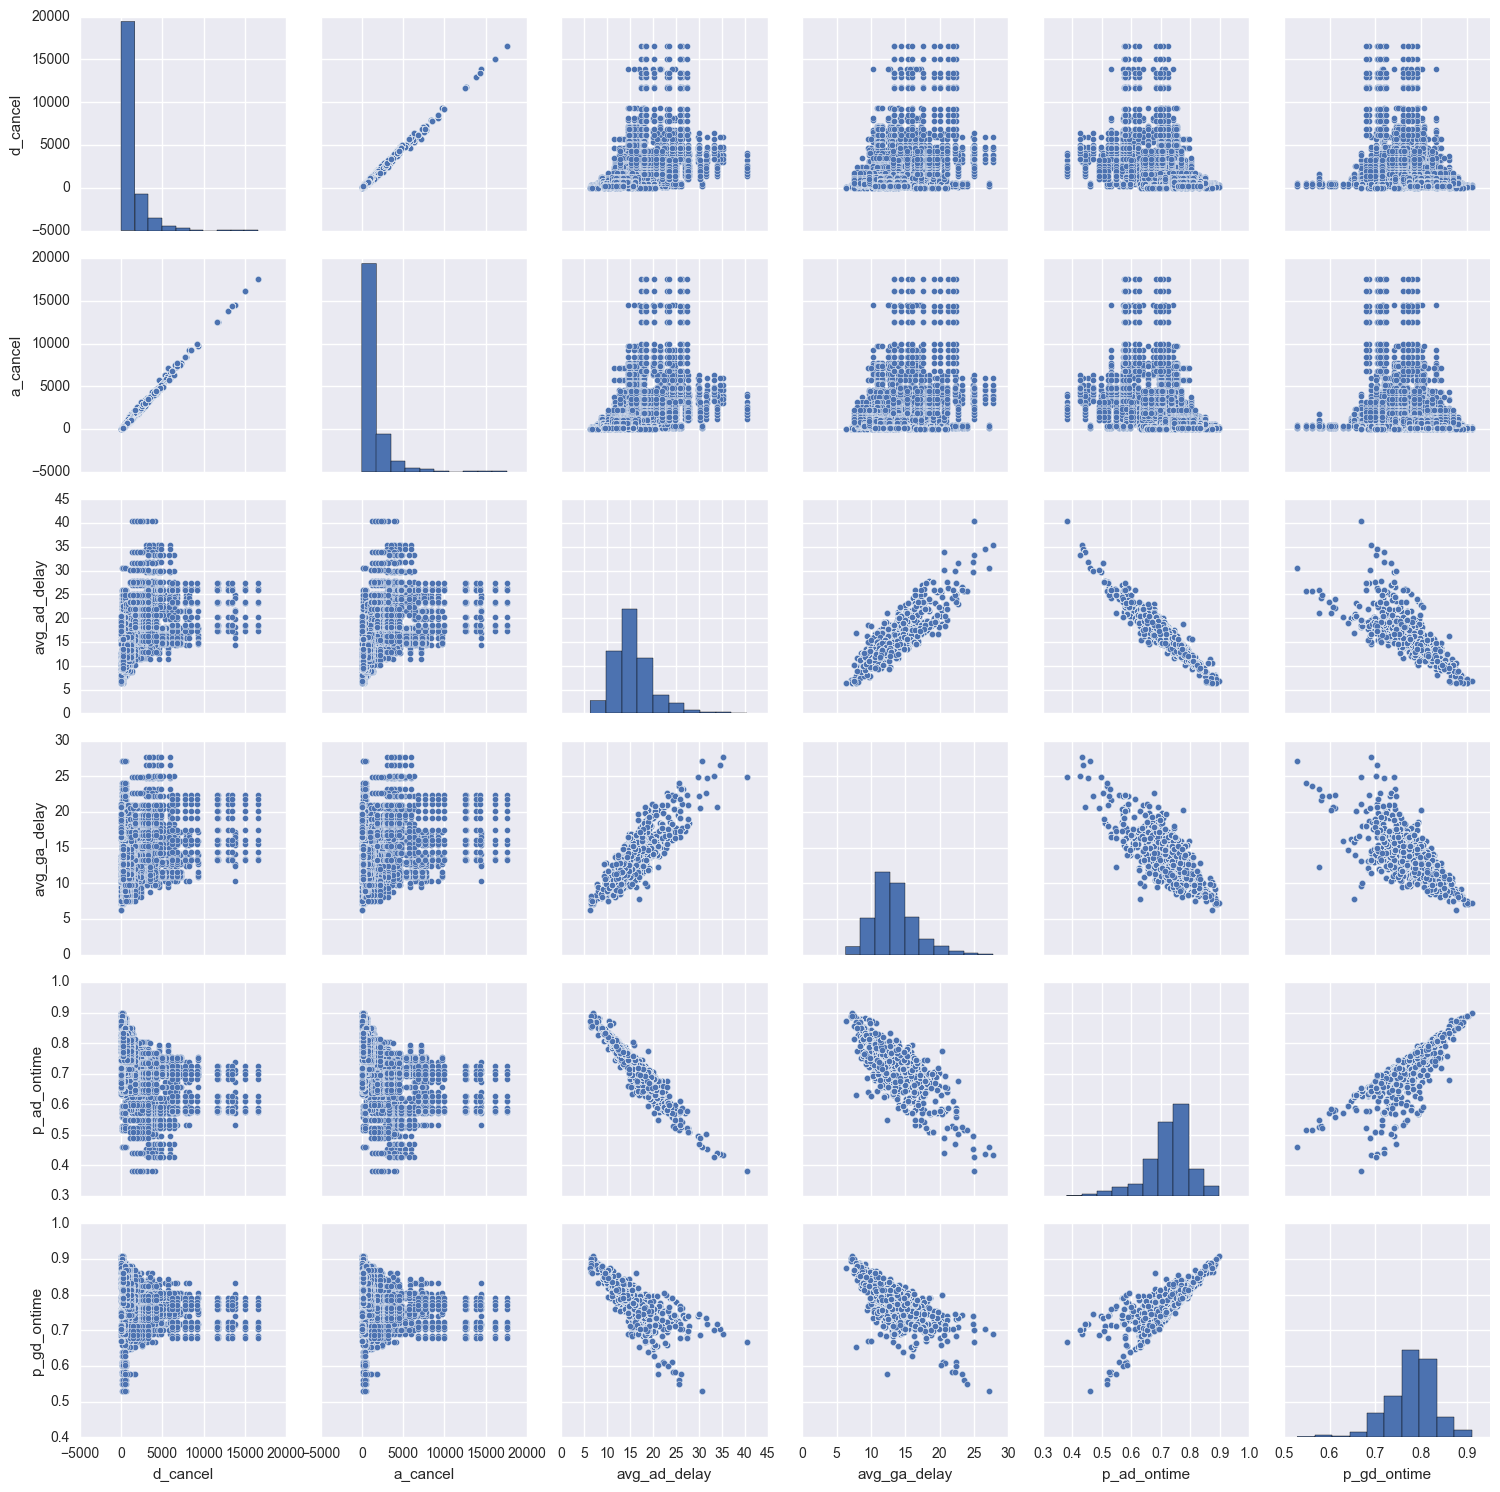

In [65]:
import seaborn as sns

sns.pairplot(df_cancellations_diversions)

In [519]:
#sns.pairplot(bad_gd_df)

In [520]:
#sns.pairplot(good_gd_df)

In [66]:
bad_gd_df.columns

Index([u'airport', u'year', u'd_cancel', u'a_cancel', u'd_diversion',
       u'a_diversion', u'key', u'locid', u'ap_name', u'alias',
       u'facility_type', u'faa_region', u'county', u'city', u'state',
       u'ap_type', u'lat', u'long', u'bda', u'airport_1', u'year_1',
       u'dep_for_mc', u'arr_for_mc', u'p_gd_ontime', u'p_ad_ontime',
       u'p_ga_ontime', u'avg_gd_delay', u'avg_taxi_out_time',
       u'avg_taxi_out_delay', u'avg_ad_delay', u'avg_airbourne_delay',
       u'avg_taxi_in_delay', u'avg_block_delay', u'avg_ga_delay'],
      dtype='object')

In [67]:
rem_columns = ['locid','ap_name','alias','facility_type','faa_region','airport_1','year_1','ap_type','bda']

In [68]:
for column in rem_columns:
    del bad_gd_df[column]
    del good_gd_df[column]
    del bad_ga_df[column]
    del good_ga_df[column]

In [69]:
bad_gd_df.head()

,airport,year,d_cancel,a_cancel,d_diversion,a_diversion,key,county,city,state,...,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,BERNALILLO,ALBUQUERQUE,NM,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,BERNALILLO,ALBUQUERQUE,NM,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,BERNALILLO,ALBUQUERQUE,NM,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,BERNALILLO,ALBUQUERQUE,NM,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,BERNALILLO,ALBUQUERQUE,NM,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


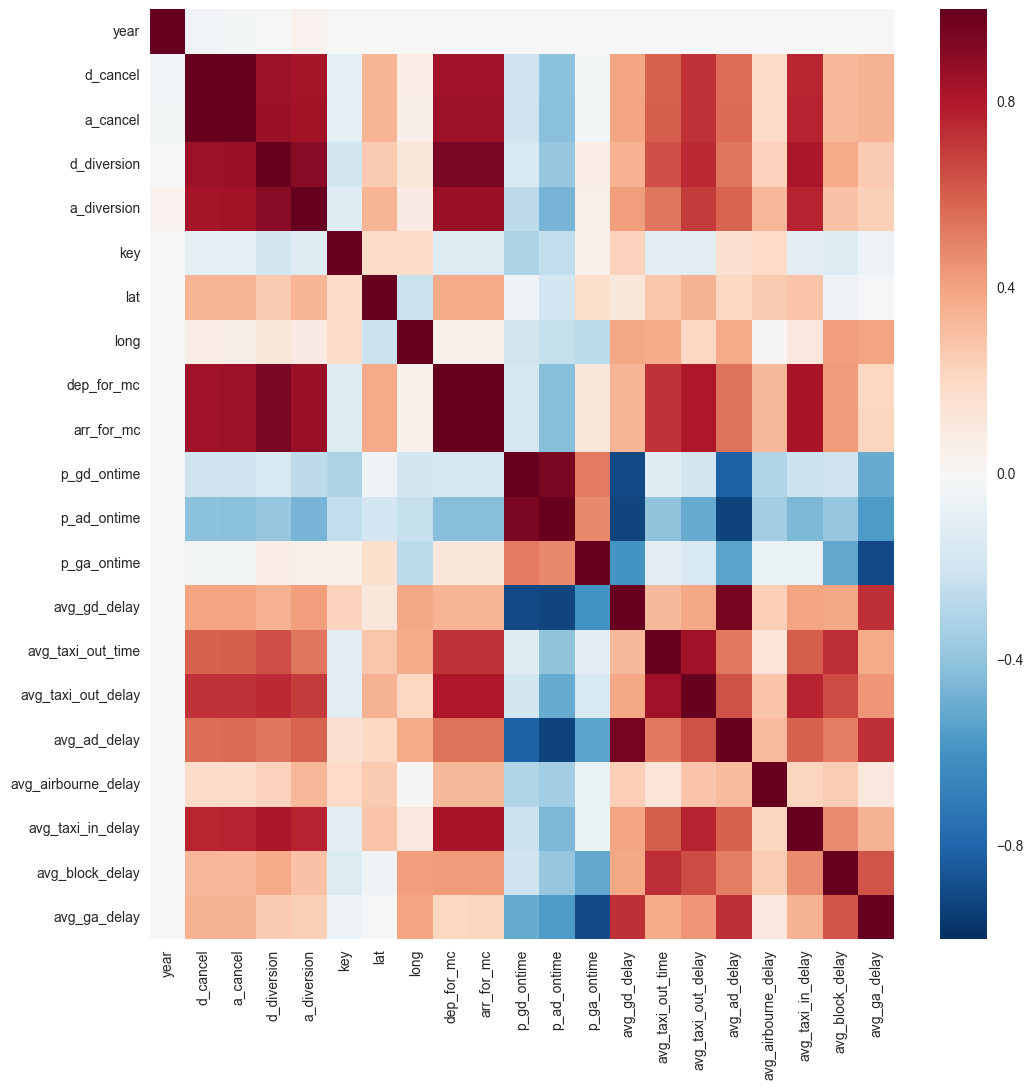

In [70]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(bad_gd_df.corr(), ax=ax)

In [71]:
bad_gd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2420 entries, 0 to 8788
Data columns (total 25 columns):
airport                2420 non-null object
year                   2420 non-null float64
d_cancel               2420 non-null float64
a_cancel               2420 non-null float64
d_diversion            2420 non-null float64
a_diversion            2420 non-null float64
key                    2420 non-null float64
county                 2420 non-null object
city                   2420 non-null object
state                  2420 non-null object
lat                    2420 non-null float64
long                   2420 non-null float64
dep_for_mc             2420 non-null int64
arr_for_mc             2420 non-null int64
p_gd_ontime            2420 non-null float64
p_ad_ontime            2420 non-null float64
p_ga_ontime            2420 non-null float64
avg_gd_delay           2420 non-null float64
avg_taxi_out_time      2420 non-null float64
avg_taxi_out_delay     2420 non-null float64
a

In [72]:
to_encode = ['airport','county','city','state']

for el in to_encode:
    bad_gd_df[el+'_enc'] = LabelEncoder().fit_transform(bad_gd_df[el])
    bad_ga_df[el+'_enc'] = LabelEncoder().fit_transform(bad_ga_df[el])
    good_gd_df[el+'_enc'] = LabelEncoder().fit_transform(good_gd_df[el])
    good_ga_df[el+'_enc'] = LabelEncoder().fit_transform(good_ga_df[el])

In [73]:
for el in to_encode:
    del bad_gd_df[el]
    del bad_ga_df[el]
    del good_gd_df[el]
    del good_ga_df[el]

In [74]:
bad_gd_df.head()

,year,d_cancel,a_cancel,d_diversion,a_diversion,key,lat,long,dep_for_mc,arr_for_mc,...,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay,airport_enc,county_enc,city_enc,state_enc
0,2004.0,242.0,235.0,71.0,46.0,2348.0,35.040194,-106.609194,53971,53818,...,2.43,12.10,2.46,0.83,2.55,10.87,0,1,0,8
1,2004.0,242.0,235.0,71.0,46.0,2348.0,35.040194,-106.609194,51829,51877,...,2.29,11.20,2.26,0.89,2.34,10.24,0,1,0,8
2,2004.0,242.0,235.0,71.0,46.0,2348.0,35.040194,-106.609194,49682,51199,...,2.16,12.33,2.12,0.84,2.66,11.82,0,1,0,8
3,2004.0,242.0,235.0,71.0,46.0,2348.0,35.040194,-106.609194,53255,53611,...,2.40,12.95,2.19,1.29,3.06,12.71,0,1,0,8
4,2004.0,242.0,235.0,71.0,46.0,2348.0,35.040194,-106.609194,49589,49512,...,2.41,12.32,1.82,1.03,2.79,11.48,0,1,0,8


In [75]:
bad_gd_df_std = StandardScaler().fit_transform(bad_gd_df)

columns = [str(column).encode('ascii') for column in bad_gd_df.columns]

bad_gd_std_df = pd.DataFrame(bad_gd_df_std,columns=columns)

In [76]:
good_gd_df_std = StandardScaler().fit_transform(good_gd_df)

columns = [str(column).encode('ascii') for column in good_gd_df.columns]

good_gd_std_df = pd.DataFrame(good_gd_df_std,columns=columns)

In [77]:
bad_ga_df_std = StandardScaler().fit_transform(bad_ga_df)

columns = [str(column).encode('ascii') for column in bad_ga_df.columns]

bad_ga_std_df = pd.DataFrame(bad_ga_df_std,columns=columns)

In [78]:
good_ga_df_std = StandardScaler().fit_transform(good_ga_df)

columns = [str(column).encode('ascii') for column in good_ga_df.columns]
good_ga_std_df = pd.DataFrame(good_ga_df_std,columns=columns)

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

<function matplotlib.pyplot.plot>

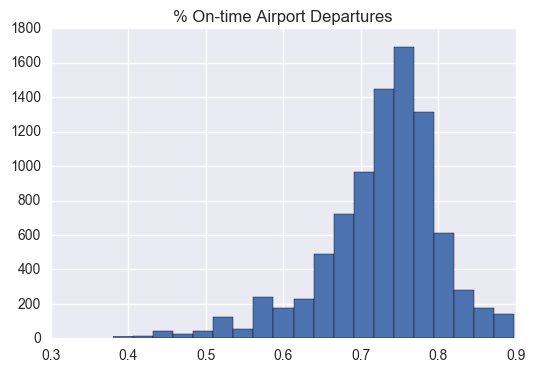

In [79]:
plt.hist(airmetrics_df['p_ad_ontime'],bins=20)
plt.title('% On-time Airport Departures')
plt.plot

<function matplotlib.pyplot.plot>

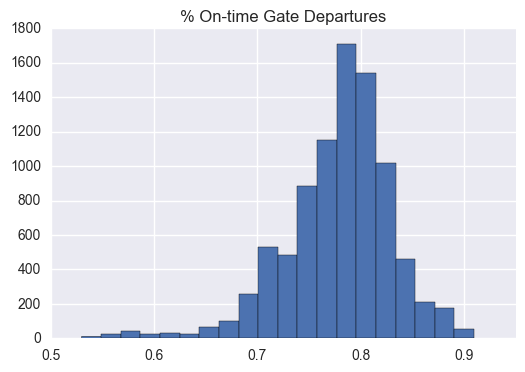

In [80]:
plt.hist(airmetrics_df['p_gd_ontime'],bins=20)
plt.title("% On-time Gate Departures")
plt.plot

<function matplotlib.pyplot.plot>

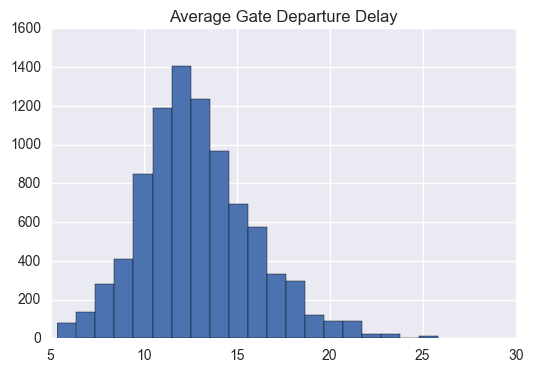

In [81]:
plt.hist(airmetrics_df['avg_gd_delay'],bins=20)
plt.title("Average Gate Departure Delay")
plt.plot

<function matplotlib.pyplot.plot>

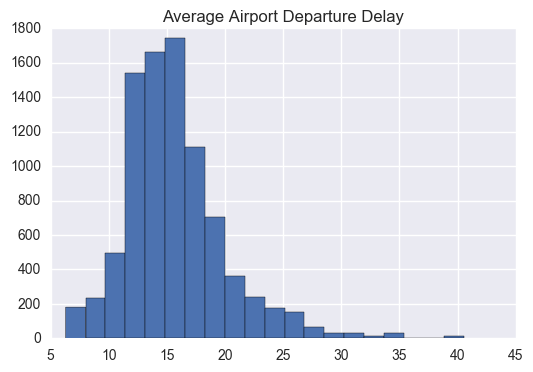

In [82]:
plt.hist(airmetrics_df['avg_ad_delay'],bins=20)
plt.title("Average Airport Departure Delay")
plt.plot

In [83]:
airmetrics_df[['year']].describe()

,year
count,8789.000000
mean,2008.986233
std,3.156287
min,2004.000000
25%,2006.000000
50%,2009.000000
75%,2012.000000
max,2014.000000


#### 4.2 Find correlations in the data

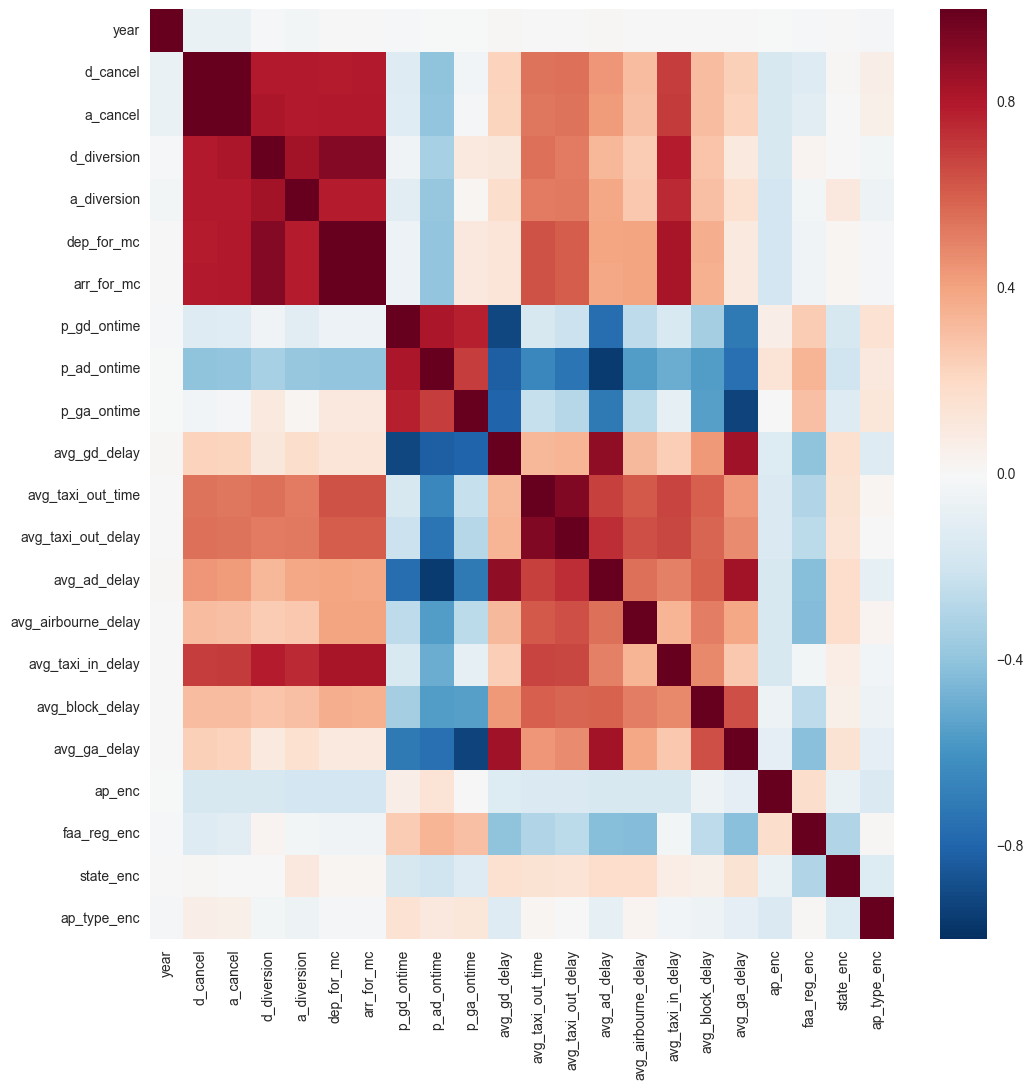

In [84]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(airmetrics_df.corr(), ax=ax)

# sns.heatmap(airmetrics_df.corr())

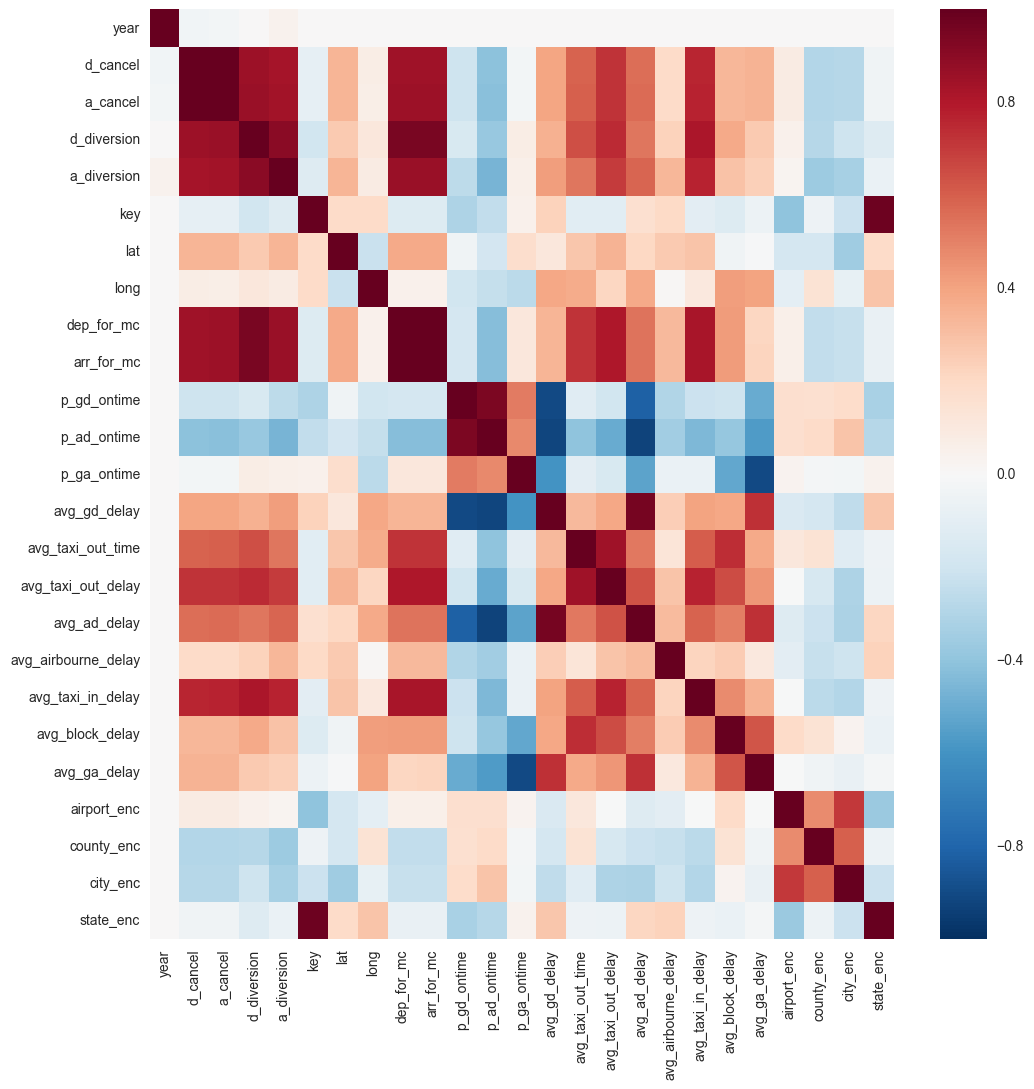

In [85]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(bad_gd_std_df.corr(), ax=ax)

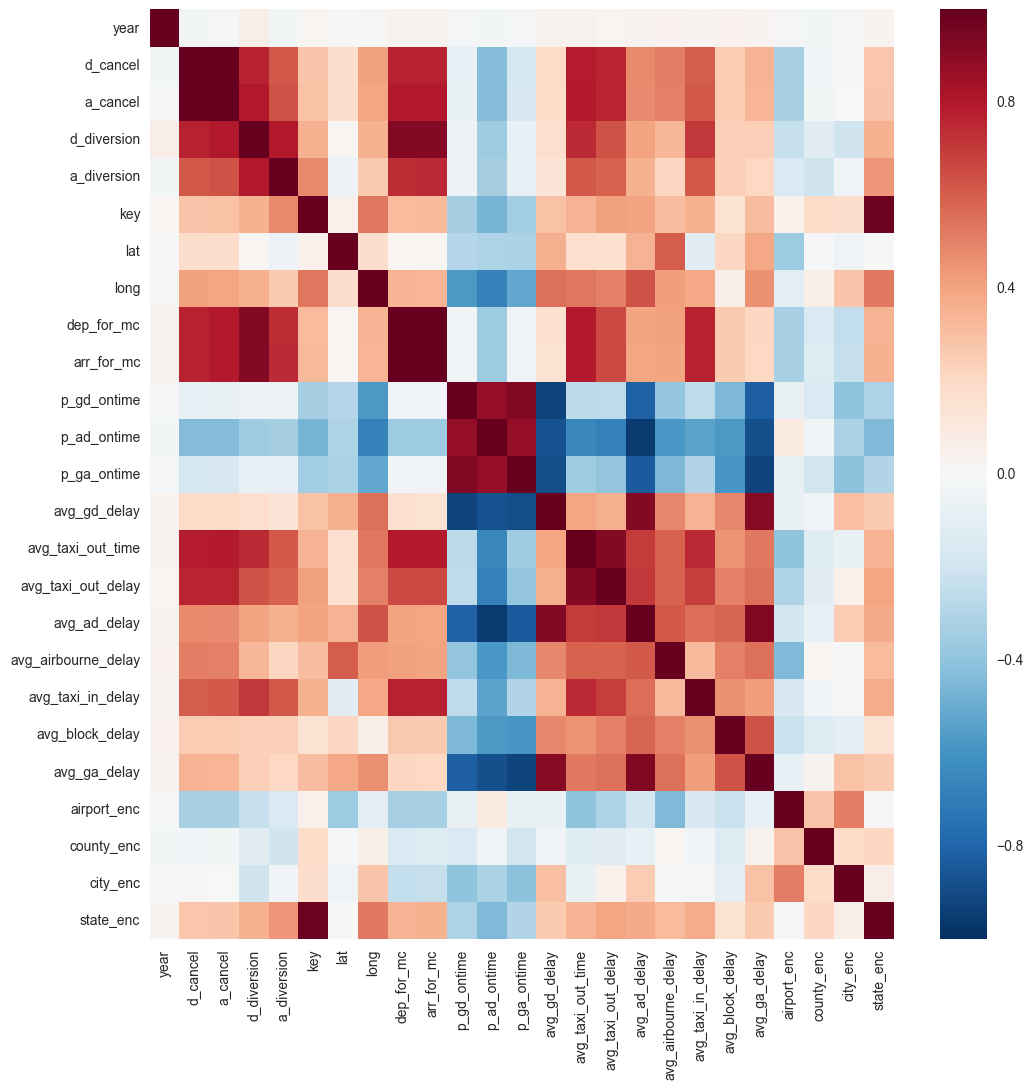

In [86]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(good_gd_std_df.corr(), ax=ax)

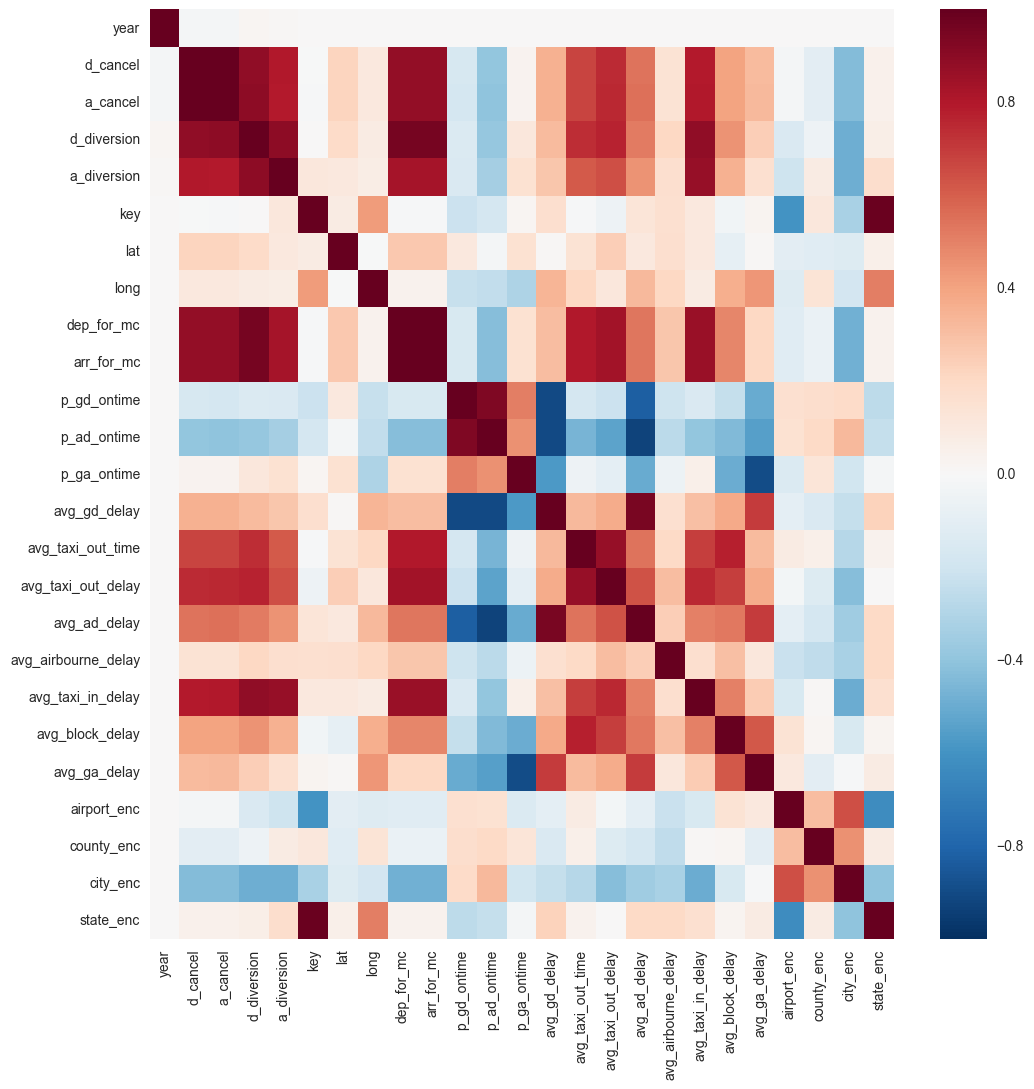

In [87]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(bad_ga_std_df.corr(), ax=ax)

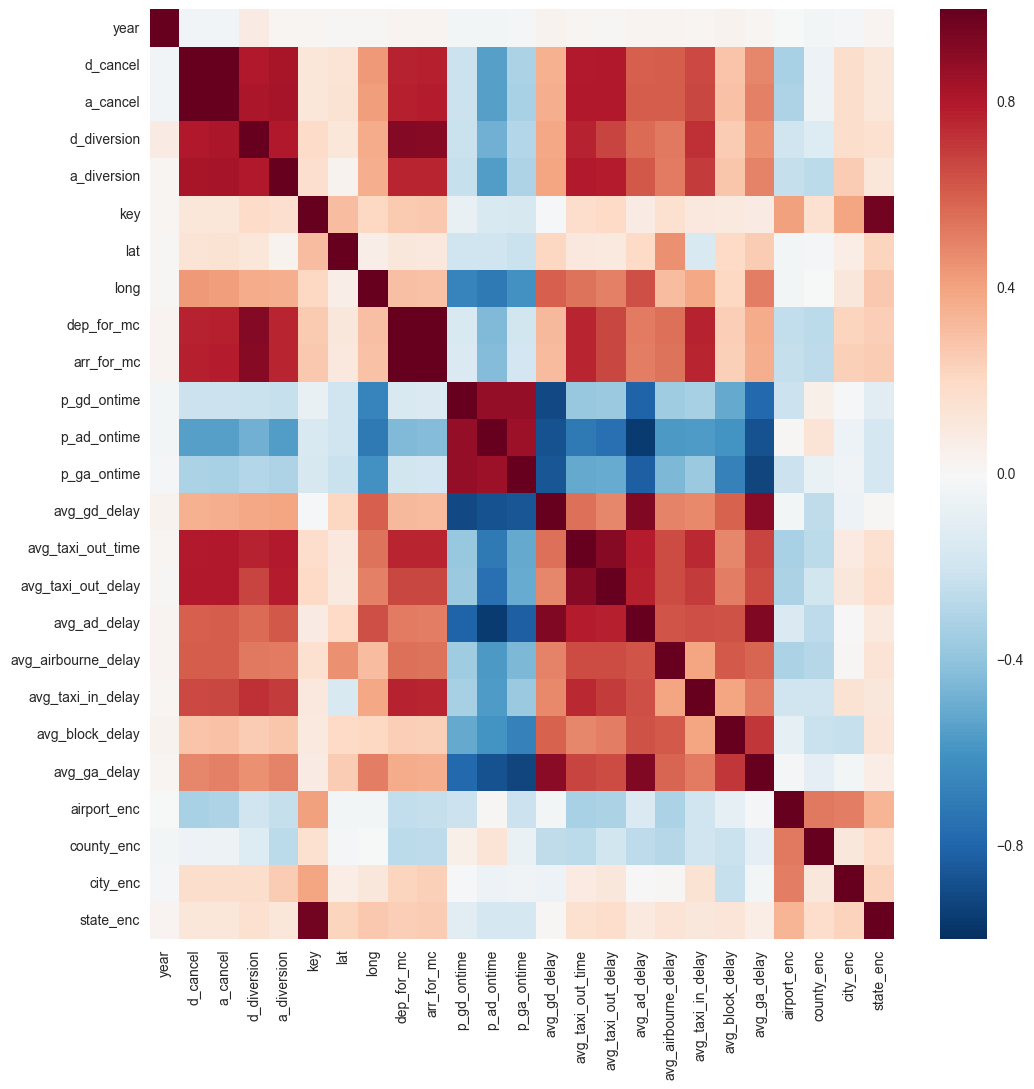

In [88]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(good_ga_std_df.corr(), ax=ax)

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: 

#### 4.4 Validate your findings using statistical analysis

In [89]:
focus_columns = ['d_cancel','a_cancel','d_diversion','a_diversion',
                'p_gd_ontime','p_ad_ontime','p_ga_ontime','avg_gd_delay',
                'avg_taxi_out_time','avg_taxi_out_delay','avg_ad_delay',
                'avg_airbourne_delay','avg_taxi_in_delay','avg_block_delay','avg_ga_delay']

In [90]:
len(focus_columns)

15

In [91]:
am_subsetdf_scaled = StandardScaler().fit_transform(airmetrics_df[focus_columns].values)

In [92]:
# from sklearn.dummy import DummyClassifier

# dumb_clf = DummyClassifier()

In [93]:
log_clf = LogisticRegression()

In [94]:
for k_val in range(2,15):
    my_kmean = KMeans(n_clusters = k_val)
    my_kmean.fit(am_subsetdf_scaled)
    lr_score = cross_val_score(log_clf,am_subsetdf_scaled,my_kmean.labels_,cv=5).mean()
    dc_score = cross_val_score(dumb_clf,am_subsetdf_scaled,my_kmean.labels_,cv=5).mean()
    s_score = silhouette_score(am_subsetdf_scaled, my_kmean.labels_)
    print "K:%s"%k_val,"G:%s"%(lr_score-dc_score),"S:%s"%s_score
    

K:2 G:0.296846717212 S:0.454296257117
K:3 G:0.52680271681 S:0.26118202811
K:4 G:0.533166807173 S:0.272843135471
K:5 G:0.610646761242 S:0.279050389308
K:6 G:0.622124409648 S:0.234700387939
K:7 G:0.603337663291 S:0.235880339663
K:8 G:0.557066465661 S:0.212336865048
K:9 G:0.560469983561 S:0.214955579192
K:10 G:0.550809578771 S:0.214831370081
K:11 G:0.501220448407 S:0.205875990037
K:12 G:0.544763595157 S:0.198687666071
K:13 G:0.527962257959 S:0.19567538045
K:14 G:0.541503878047 S:0.204937237197


In [95]:
# We have our optimal value of K at 6 clusters.

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [124]:
# Alternate PCA work based on some of the discussions on Friday.

In [128]:
airmetrics_df.columns


Index([u'year', u'd_cancel', u'a_cancel', u'd_diversion', u'a_diversion',
       u'dep_for_mc', u'arr_for_mc', u'p_gd_ontime', u'p_ad_ontime',
       u'p_ga_ontime', u'avg_gd_delay', u'avg_taxi_out_time',
       u'avg_taxi_out_delay', u'avg_ad_delay', u'avg_airbourne_delay',
       u'avg_taxi_in_delay', u'avg_block_delay', u'avg_ga_delay', u'ap_enc',
       u'faa_reg_enc', u'state_enc', u'ap_type_enc'],
      dtype='object')

In [132]:
del airmetrics_df[u'year']

In [133]:
del airmetrics_df[u'ap_enc']

In [134]:
del airmetrics_df[u'state_enc']

In [135]:
del airmetrics_df[u'ap_type_enc']

In [136]:
airmetrics_df.head()

,d_cancel,a_cancel,d_diversion,a_diversion,dep_for_mc,arr_for_mc,p_gd_ontime,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay,faa_reg_enc
0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,7
1,242.0,235.0,71.0,46.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24,7
2,242.0,235.0,71.0,46.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82,7
3,242.0,235.0,71.0,46.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71,7
4,242.0,235.0,71.0,46.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48,7


In [140]:
from sklearn.preprocessing import scale,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## New PCA analysis based on some of the discussions later on in the week

In [139]:
XX = StandardScaler().fit_transform(airmetrics_df)

In [294]:
km1 = KMeans(n_clusters=2, n_init=20)
km1.fit(XX)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [295]:
km1.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [175]:
km1.inertia_

55878.082737421093

In [183]:
print silhouette_score(XX, km1.labels_, metric='euclidean'), km1.inertia_

 0.224260050554 55878.0827374


In [279]:
for k_val in range(2,12):
    kmd = KMeans(n_clusters=k_val)
    kmd.fit(XX)
    print 'K:%s'%k_val,'SC:%s'%silhouette_score(XX,kmd.labels_,metric='euclidean'),'I:%s'%kmd.inertia_

K:2 SC:0.409395896309 I:106729.962626
K:3 SC:0.225171936051 I:88545.506716
K:4 SC:0.246993310692 I:74539.1788476
K:5 SC:0.263624674378 I:62402.3633439
K:6 SC:0.224260050554 I:55878.1347777
K:7 SC:0.219847681204 I:52430.4642017
K:8 SC:0.204226435961 I:49417.8519844
K:9 SC:0.197735094743 I:46681.4944956
K:10 SC:0.205590660475 I:44070.1668065
K:11 SC:0.206072935356 I:41969.2300819


In [278]:
km2 = KMeans(n_clusters=6, n_init=20)
km2.fit(XX)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [515]:
#fig, (ax1) = plt.subplots(1, figsize=(5,5))

#ax1.scatter(XX[:,0], XX[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
#ax1.set_title('K-Means Clustering Results with K=2')
#ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

In [516]:
#sns.pairplot(pd.DataFrame(XX))

In [200]:
# Run PCA analysis

am_pca = PCA()

In [201]:
am_pca.fit(XX)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [202]:
am_mx = am_pca.fit_transform(XX)

In [209]:
am_inv = am_pca.inverse_transform(am_mx)

In [210]:
np.allclose(am_inv,XX)

True

In [528]:
am_red_pca = PCA(n_components=3)

In [529]:
am_red_X = am_red_pca.fit_transform(XX)

In [530]:
am_red_X.shape

(8789, 3)

In [449]:
redk = KMeans(n_clusters=6)
redkf = redk.fit(am_red_X)

In [450]:
am_red_X[:,0]

array([-2.74593681, -3.0971185 , -2.63320764, ..., -3.86065203,
       -2.95307522, -2.30969984])

In [451]:
np.unique(redkf.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [452]:
dfredx = pd.DataFrame({'X1':am_red_X[:,0],'X2':am_red_X[:,1],'y':redkf.labels_})

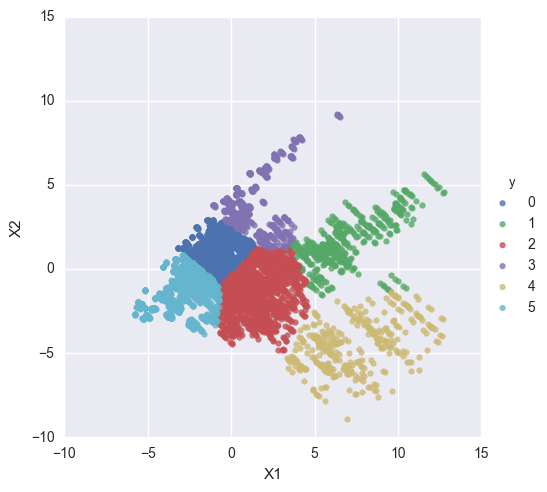

In [453]:
sns.lmplot('X1','X2',data=dfredx, fit_reg=False, hue='y')

In [454]:
from sklearn.manifold import TSNE

my_red_tsne = TSNE(n_components=2)

In [281]:
redts = my_red_tsne.fit_transform(am_red_X)

array([[ 0.56188173,  3.80112768],
       [-1.72066842, -6.87565952],
       [ 1.90289546,  6.10639762],
       ..., 
       [ 5.67155624, -8.58831069],
       [ 0.91712255,  2.48485374],
       [ 5.79379171,  0.06919979]])

In [292]:
dftsx = pd.DataFrame({'X1':redts[:,0],'X2':redts[:,1],'y':redkf.labels_})

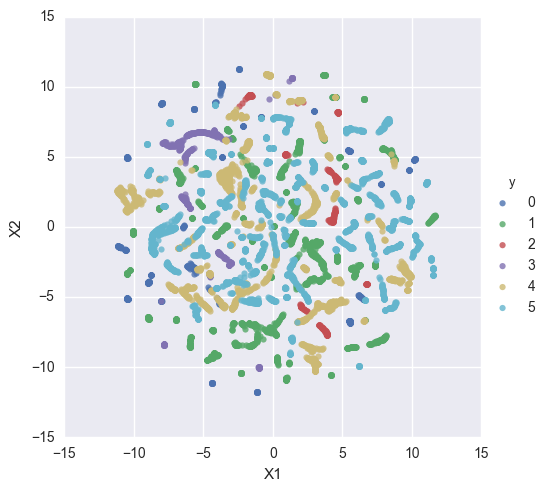

In [293]:
sns.lmplot('X1','X2',data=dftsx, fit_reg=False, hue='y')

# ------------ PREVIOUS WORK BELOW ------------------

In [96]:
# PCA on overall operations 
# Cluster on Bad Airports (already done above)

# Optional Consideration:Lasso to reduce features to match number of dimensions?


In [97]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

X = airmetrics_df

In [98]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

In [99]:
covMat = np.cov(X_scaled.T)

In [100]:
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [101]:
print(eigenValues)

[  9.05942333e+00   4.46243325e+00   1.43604065e+00   1.16358492e+00
   1.13644341e+00   1.00601921e+00   7.62797673e-01   6.94453555e-01
   5.95618159e-01   4.51832331e-01   3.70522941e-01   2.27926971e-01
   1.95034865e-01   1.71269921e-01   1.16822359e-01   6.54254561e-02
   6.27750732e-02   1.62491758e-02   4.97634700e-03   1.68939939e-03
   1.68375713e-04   9.96036921e-04]


In [102]:
#print(eigenVectors)

In [103]:
print len(eigenValues)
print len(eigenVectors)

22
22


In [104]:
eig_pairs = [(np.abs(eigenValues[i]),eigenVectors[:,i]) for i in range(len(eigenValues))]

In [107]:
 totalEigen = sum(eigenValues)
 varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [108]:
pcasum = np.cumsum(varExpl)

In [109]:
print pcasum

[  41.17451165   61.45599131   67.9827061    73.27112668   78.4361908
   83.00848513   86.47535278   89.63160069   92.33864792   94.39219757
   96.07620113   97.11211493   97.99853618   98.77694725   99.30789755
   99.60525216   99.89056093   99.96441242   99.9870296    99.99470782
   99.99923474  100.        ]


In [110]:
from sklearn.decomposition import PCA
%matplotlib inline

my_PCA = PCA(n_components=6)
x2_pca = my_PCA.fit_transform(X_scaled)

In [111]:
my_PCA.explained_variance_ratio_

array([ 0.41174512,  0.2028148 ,  0.06526715,  0.05288421,  0.05165064,
        0.04572294])

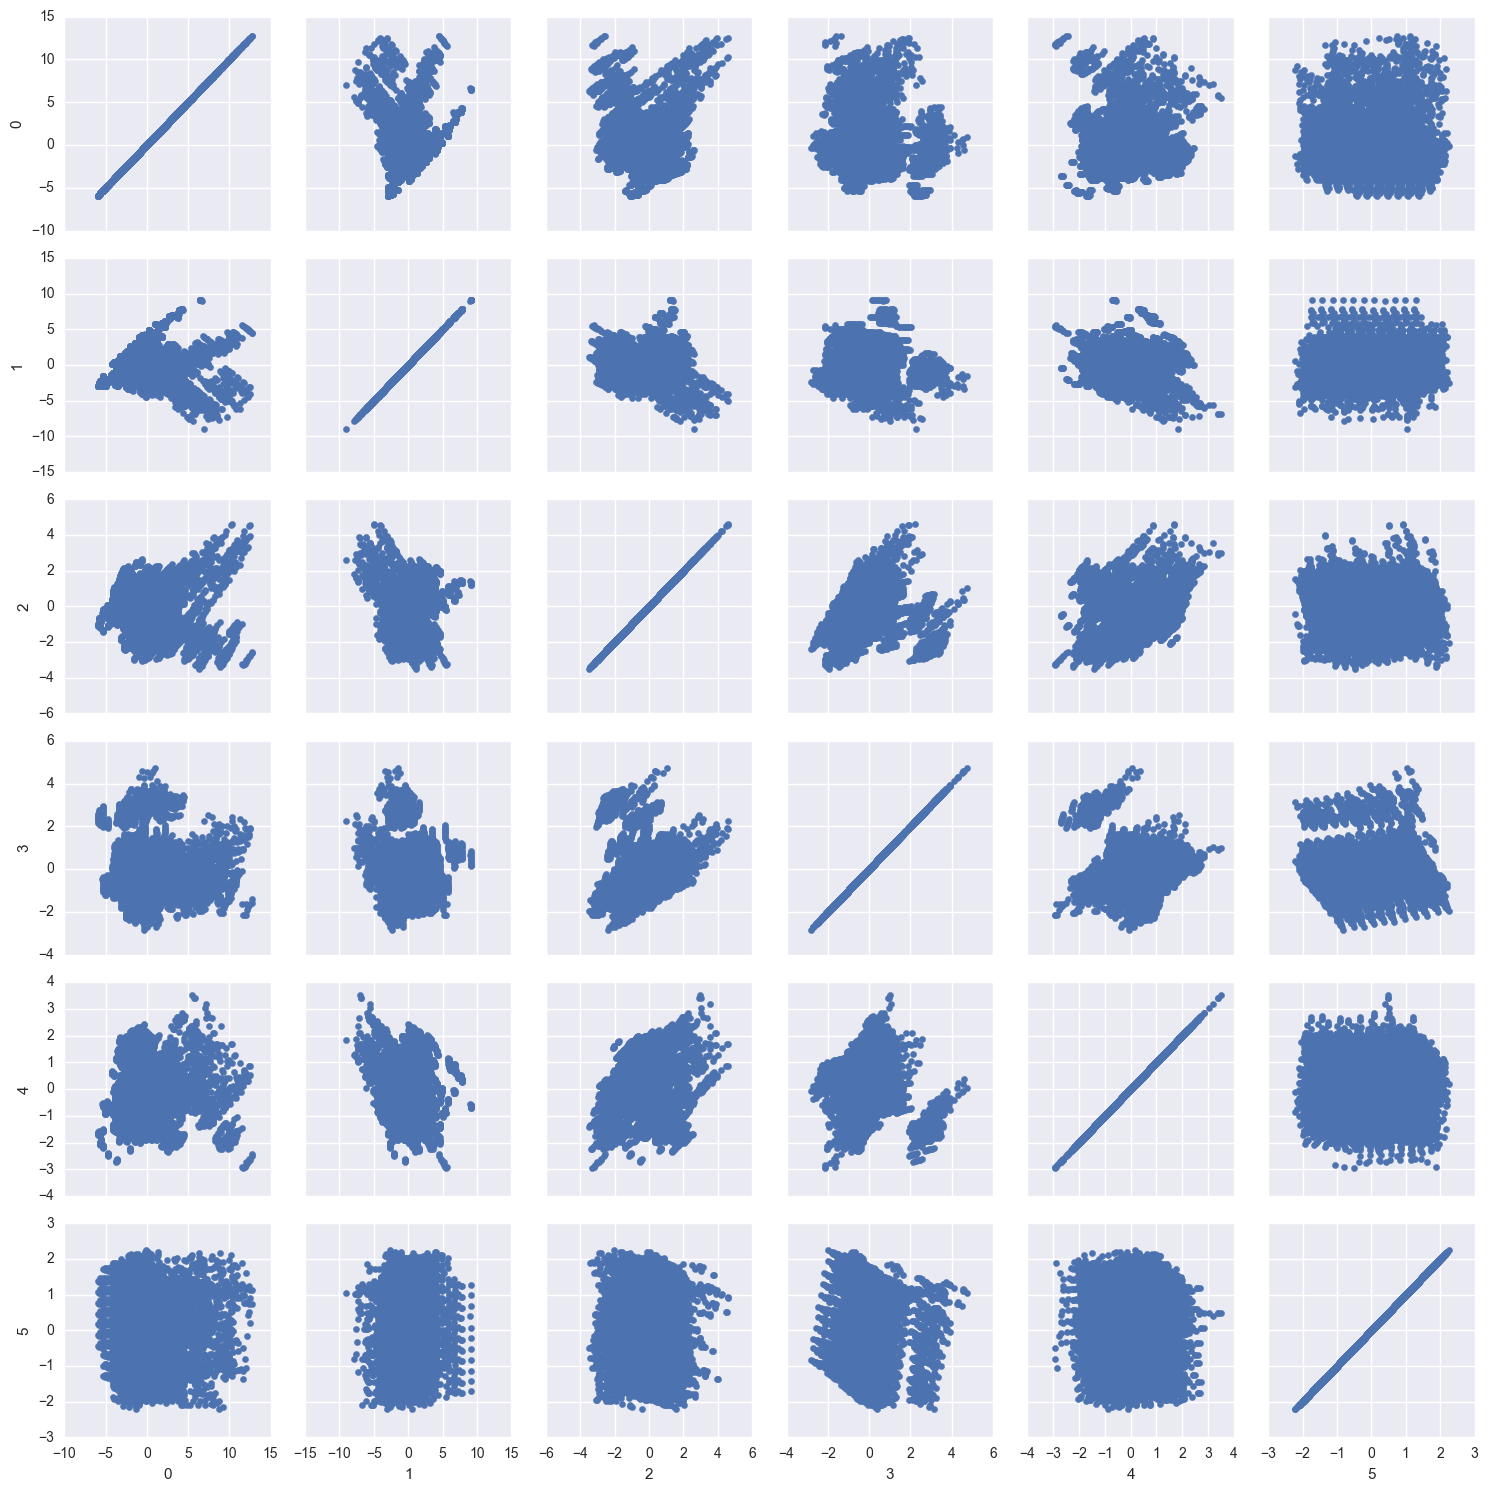

In [112]:
pg_pca = pd.DataFrame(x2_pca)

g = sns.PairGrid(pg_pca)
g = g.map(plt.scatter)

In [ ]:
# from sklearn.manifold import TSNE

# my_tsne = TSNE(n_components=6)
# x2_tsne = my_tsne.fit_transform(X_scaled)

In [ ]:
# pg_tsne = pd.DataFrame(x2_tsne)

# g = sns.PairGrid(pg_tsne)
# g = g.map(plt.scatter)

In [113]:
am_avg=airmetrics_df[airmetrics_df['year']>=2012].groupby('ap_enc').mean()

In [120]:
am_avg[focus_columns].head()

,d_cancel,a_cancel,d_diversion,a_diversion,p_gd_ontime,p_ad_ontime,p_ga_ontime,avg_gd_delay,avg_taxi_out_time,avg_taxi_out_delay,avg_ad_delay,avg_airbourne_delay,avg_taxi_in_delay,avg_block_delay,avg_ga_delay
ap_enc,,,,,,,,,,,,,,,
0,261.333333,222.333333,64.333333,47.666667,0.801800,0.775791,0.786673,10.964545,10.211818,2.319091,12.534545,1.870000,0.955455,2.336364,11.314545
1,156.000000,210.000000,72.333333,34.666667,0.796600,0.770364,0.778991,14.769091,12.317273,1.977273,16.006364,4.100000,0.582727,4.797273,15.675455
2,3717.333333,4238.333333,816.333333,655.000000,0.771836,0.633418,0.771736,13.477273,19.768182,7.777273,20.069091,3.278182,3.586364,4.200000,14.543636
3,409.000000,358.666667,84.000000,79.000000,0.793200,0.769582,0.751900,11.893636,11.561818,2.272727,13.444545,2.167273,1.055455,2.876364,13.931818
4,375.333333,336.333333,50.000000,25.000000,0.807273,0.765327,0.761436,11.766364,13.052727,3.106364,14.011818,2.860909,0.966364,3.130000,13.719091


In [338]:
X_alt_scale.shape

(73, 15)

In [123]:
from sklearn.preprocessing import scale

X_alt_scale = pd.DataFrame(scale(am_avg[focus_columns]),columns=focus_columns)

pca_loadings = pd.DataFrame(PCA().fit(X_alt_scale).components_.T, index=X_alt_scale.columns, columns=['V1', 'V2', 'V3', 'V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15'])
pca_loadings

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
d_cancel,0.260624,-0.272945,0.255294,0.028475,0.332288,0.296521,0.289502,-0.077228,0.083360,0.081612,-0.068354,-0.054423,-0.238139,-0.652160,0.014440
a_cancel,0.259788,-0.280445,0.255200,0.031391,0.299765,0.278192,0.275788,-0.081445,0.149158,0.028593,-0.039464,-0.015785,0.274954,0.661247,-0.009335
d_diversion,0.225919,-0.347448,0.196735,0.034279,-0.226370,-0.141648,-0.371931,0.043611,0.403478,-0.637659,-0.034845,-0.053539,-0.038399,-0.041636,0.011231
a_diversion,0.239980,-0.307519,0.263556,-0.037443,-0.193508,0.020411,-0.294429,-0.109251,-0.790018,0.059571,-0.100619,0.037255,0.027709,0.022771,-0.003923
p_gd_ontime,-0.198688,-0.343815,-0.308486,0.312292,0.350705,0.017437,-0.196610,0.253117,-0.121024,-0.050647,0.234891,-0.184270,0.527698,-0.196950,0.002413
p_ad_ontime,-0.308688,-0.179419,0.044184,0.303467,0.090171,0.158840,-0.160943,0.379917,-0.031306,0.105756,-0.177549,-0.285551,-0.614667,0.261433,0.059029
p_ga_ontime,-0.181014,-0.402096,-0.174618,-0.254115,-0.204406,0.078520,0.401326,0.379536,-0.111576,-0.184329,0.186557,0.508365,-0.120417,0.024784,-0.051490
avg_gd_delay,0.251053,0.316880,0.217818,-0.109328,-0.073876,0.029597,0.135173,0.609654,-0.100578,-0.091996,0.001484,-0.305757,0.143187,-0.050444,-0.495745
avg_taxi_out_time,0.284252,-0.094141,-0.421413,0.058865,0.107424,-0.322424,0.138473,0.135755,-0.024018,0.004147,-0.752713,0.079633,0.046841,-0.002798,0.021631
avg_taxi_out_delay,0.291122,-0.088575,-0.384593,-0.113775,0.302852,-0.251953,0.008572,-0.241700,-0.124835,-0.124456,0.385348,-0.174319,-0.395192,0.148584,-0.380323


In [518]:
alt_pca = PCA()
pca_plot = pd.DataFrame(alt_pca.fit_transform(X_alt_scale), columns=['V1', 'V2', 'V3', 'V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15'], index=X_alt_scale.index)
#pca_plot

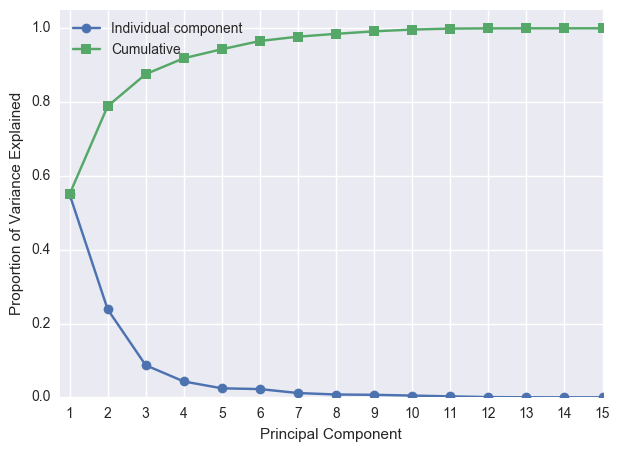

In [117]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], alt_pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], np.cumsum(alt_pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.legend(loc=2);

In [342]:
pca_ap_df = pd.DataFrame((np.unique(airmetrics_raw[airmetrics_raw['year']>2012][['airport']])).T)

In [370]:
len(pca_ap_df)

73

In [326]:
pca_plot

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,-2.816932,-0.241380,0.423151,-0.383505,0.369626,-0.306494,-0.042435,-0.132232,-0.011135,0.064465,0.174166,-0.002996,-0.010177,0.002516,0.003085
1,-0.335236,1.344322,-0.994336,1.564718,-0.982304,1.721149,0.163150,0.953678,-0.248832,-0.515168,0.289219,0.133799,0.036095,0.020220,-0.021426
2,5.558250,-3.578209,0.622731,0.069725,-0.714021,-1.140097,-0.775001,-0.180685,0.416103,-0.727303,0.262136,0.025912,0.037257,-0.007108,0.001399
3,-1.689217,0.448480,0.464926,0.431128,0.385430,-0.150021,-0.425828,-0.065859,0.010762,0.169806,-0.047605,0.093046,-0.003193,-0.004261,0.014408
4,-1.426253,0.413377,-0.541630,0.432998,0.429688,0.208074,-0.254300,0.011685,0.031122,0.110793,-0.029568,0.014765,0.028238,-0.003557,0.005236
5,-1.271274,1.512836,0.664868,0.219523,0.744294,-0.451204,-0.367460,-0.081862,-0.033295,0.051221,-0.036539,-0.000368,0.036630,0.015220,-0.007552
6,-1.117152,0.371261,0.578568,-0.286046,0.286901,0.182174,-0.153083,0.082125,0.201898,-0.129702,-0.016001,0.020749,-0.033448,-0.031824,-0.012222
7,2.083143,-0.368950,-1.344293,0.898911,0.065560,0.370456,-0.222403,0.055333,0.591591,-0.098023,-0.160177,-0.094186,-0.079165,-0.035186,-0.001476
8,-0.333891,1.841720,0.316812,0.128004,0.489661,0.054263,-0.187288,0.408853,-0.024152,0.057338,0.052606,0.014388,0.041967,-0.007558,-0.017340
9,-3.021079,-0.251685,0.156270,-0.698029,0.613178,0.110460,0.005966,-0.342237,-0.012121,-0.013514,-0.249632,-0.003188,-0.006878,0.020407,0.016149


In [354]:
pca_ap_df.loc[0].values[0].encode('ascii')

'ABQ'

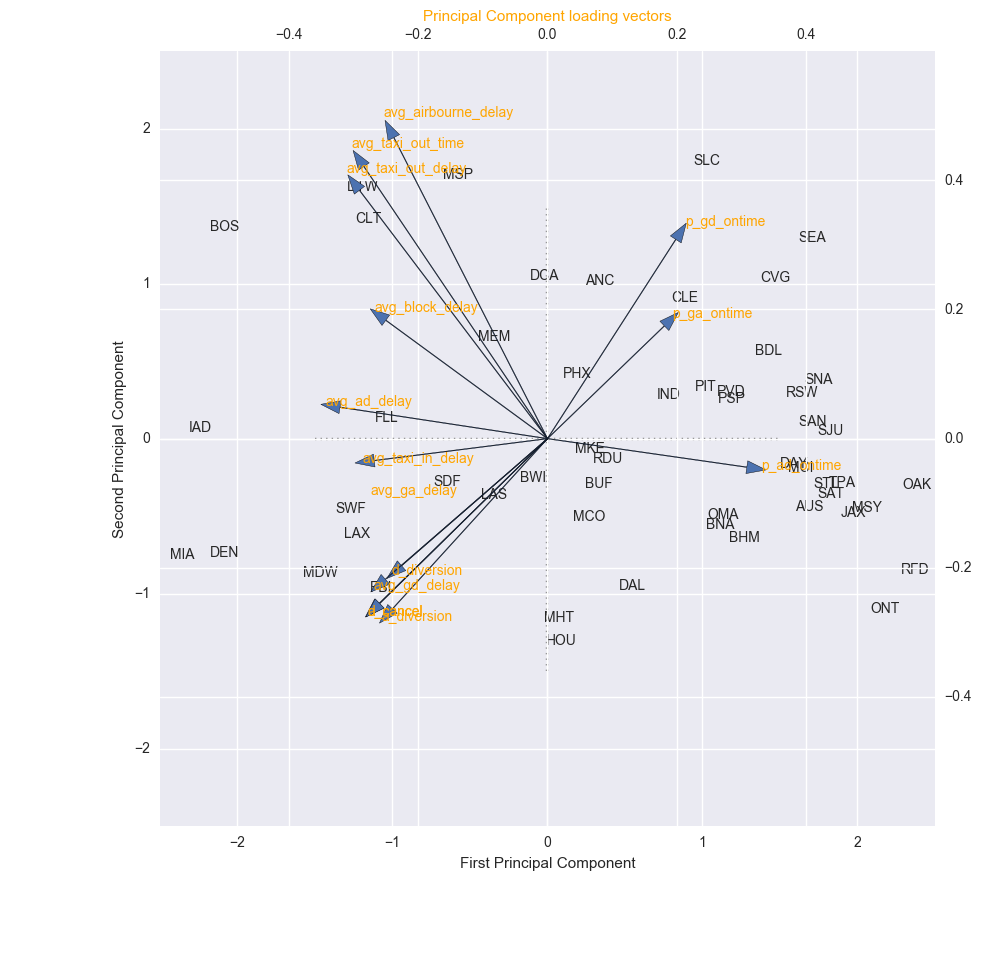

In [514]:
fig , ax1 = plt.subplots(figsize=(10,10))

ax1.set_xlim(-2.5,2.5)
ax1.set_ylim(-2.5,2.5)

# Plot Principal Components 1 and 2
for i in range(0,len(pca_ap_df)):
    ax1.annotate(pca_ap_df.loc[i].values[0].encode('ascii'), (-pca_plot.V1.loc[i], -pca_plot.V3.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-1.5,1.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-1.5,1.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')


ax2 = ax1.twinx().twiny() 
ax2.set_ylim(-.6,.6)
ax2.set_xlim(-.6,.6)

ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

a = 1.07  
for i in pca_loadings[['V1', 'V3']].index:
    ax2.annotate(i, (-pca_loadings.V1.loc[i]*a, -pca_loadings.V3.loc[i]*a), color='orange')

# Plot vector
ax2.arrow(0,0,-pca_loadings.V1[0], -pca_loadings.V3[0])
ax2.arrow(0,0,-pca_loadings.V1[1], -pca_loadings.V3[1])
ax2.arrow(0,0,-pca_loadings.V1[2], -pca_loadings.V3[2])
ax2.arrow(0,0,-pca_loadings.V1[3], -pca_loadings.V3[3])
ax2.arrow(0,0,-pca_loadings.V1[4], -pca_loadings.V3[4])
ax2.arrow(0,0,-pca_loadings.V1[5], -pca_loadings.V3[5])
ax2.arrow(0,0,-pca_loadings.V1[6], -pca_loadings.V3[6])
ax2.arrow(0,0,-pca_loadings.V1[7], -pca_loadings.V3[7])
ax2.arrow(0,0,-pca_loadings.V1[8], -pca_loadings.V3[8])
ax2.arrow(0,0,-pca_loadings.V1[9], -pca_loadings.V3[9])
ax2.arrow(0,0,-pca_loadings.V1[10], -pca_loadings.V3[10])
ax2.arrow(0,0,-pca_loadings.V1[11], -pca_loadings.V3[11])
ax2.arrow(0,0,-pca_loadings.V1[12], -pca_loadings.V3[12])
ax2.arrow(0,0,-pca_loadings.V1[13], -pca_loadings.V3[13])


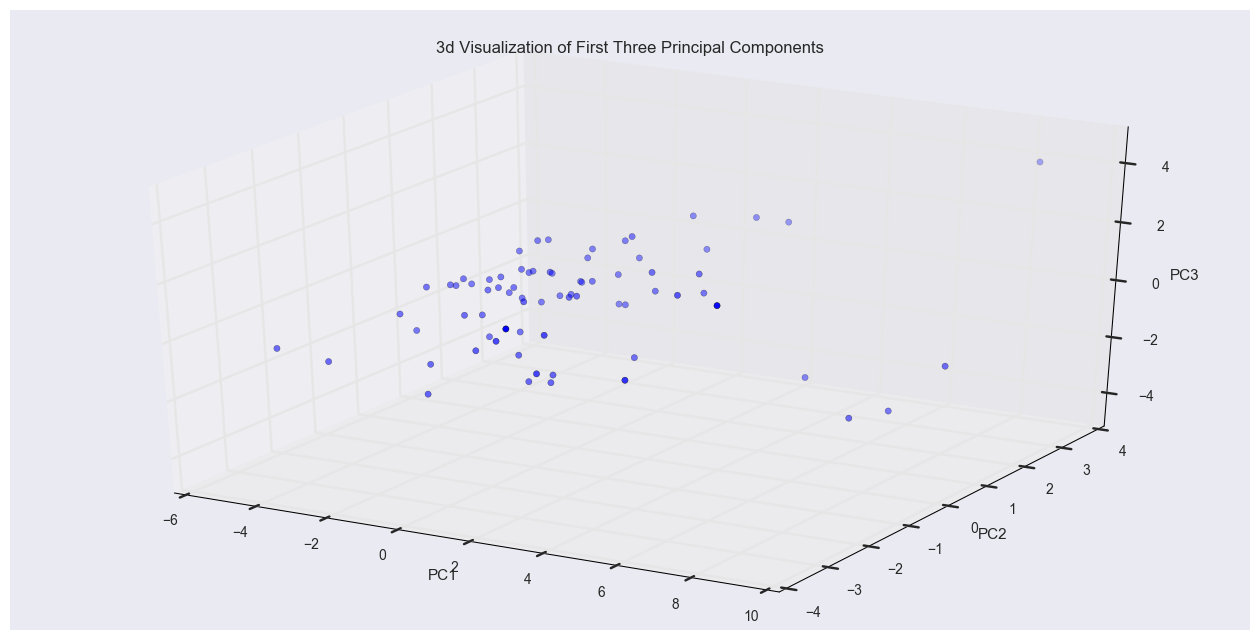

In [533]:
from mpl_toolkits.mplot3d import Axes3D

airmetrics_3d = plt.figure(figsize=(16,8)).gca(projection='3d')

airmetrics_3d.scatter(pca_plot['V1'], pca_plot['V2'], pca_plot['V3'])

airmetrics_3d.set_xlabel('PC1')
airmetrics_3d.set_ylabel('PC2')
airmetrics_3d.set_zlabel('PC3')

airmetrics_3d.set_xlim(-15,15)
airmetrics_3d.set_ylim(-15,15)
airmetrics_3d.set_zlim(-5,5)

plt.axis('equal')
plt.title('3d Visualization of First Three Principal Components')
plt.show()


#### 5.2 Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

# What aspects of airport operations have an impact on delays?

- hint : correlations between arrivals cancellations, departure cancellations is significant

- Focus on which airports have no improvements over the 10 year period
- Check which features have most contribution (highest variance) on on delays. 
- PCA on overall operations to reduce on dimensions (use PCA graph!), then clustering on cancellations
- check 10.6.1 on ISLR

- PCA Overall, cluster -> separate good/bad
- 2nd PCA on BAD to find features with highest contributions to delays. 